In [17]:
import scanpy as sc

import muon as mu

from muon import atac as ac
from muon import prot as pt

import scipy
import numpy as np 
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd

In [18]:
!pwd

/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core


In [19]:
def write_dataset(data, path, sep='\t', header=True, index=True, compression=None):
    """
    See pandas.to_csv documentation - this is just a wrapper
    :param data: data to save
    :param path: str or Path object, path to save
    :param sep:
    :param header:
    :param index:
    :param compression:
    :return:
    """
    from pathlib import Path

    if isinstance(path, str):
        path = Path(path)

    output_dir = path.parents[0]
    output_dir.mkdir(parents=True, exist_ok=True)

    return data.to_csv(
        path, sep=sep, header=header, index=index, compression=compression
    )

In [20]:
sc.__version__

'1.11.1'

In [21]:
def axis_net(x, y, title='', x_len=4, y_len=4, title_y=1, gridspec_kw=None):
    """
    Return an axis iterative for subplots arranged in a net
    :param x: int, number of subplots in a row
    :param y: int, number of subplots in a column
    :param title: str, plot title
    :param x_len: float, width of a subplot in inches
    :param y_len: float, height of a subplot in inches
    :param gridspec_kw: is used to specify axis ner with different rows/cols sizes.
            A dict: height_ratios -> list + width_ratios -> list
    :param title_y: absolute y position for suptitle
    :return: axs.flat, numpy.flatiter object which consists of axes (for further plots)
    """
    if x == y == 1:
        fig, ax = plt.subplots(figsize=(x * x_len, y * y_len))
        af = ax
    else:
        fig, axs = plt.subplots(
            y, x, figsize=(x * x_len, y * y_len), gridspec_kw=gridspec_kw
        )
        af = axs.flat

    fig.suptitle(title, y=title_y)
    return af



#sc.pl.umap(adata_aggregated, color=['sample','phase' ], color_map='Blues', )

In [22]:
def bot_bar_plot(
    data,
    palette=None,
    lrot=0,
    figsize=(5, 5),
    title='',
    ax=None,
    order=None,
    stars=False,
    percent=False,
    pvalue=False,
    p_digits=5,
    legend=True,
    xl=True,
    offset=-0.1,
    linewidth=0,
    align='center',
    bar_width=0.9,
    edgecolor=None,
    hide_grid=True,
    draw_horizontal=False,
    plot_all_borders=True,
    **kwargs
):
    """
    Plot a stacked bar plot based on contingency table

    Parameters
    ----------
    data: pd.DataFrame
        contingency table for plotting. Each element of index corresponds to a bar.
    palette: dict
        palette for plotting. Keys are unique values from groups, entries are color hexes
    lrot: float
        rotation angle of bar labels in degrees
    figsize: (float, float)
        figure size in inches
    title: str
        plot title
    ax: matplotlib axis
        axis to plot on
    order: list
        what order to plot the stacks of each bar in. Contains column labels of "data"
    stars: bool
        whether to use the star notation for p value instead of numerical value
    percent: bool
        whether to normalize each bar to 1
    pvalue: bool
        whether to add the p value (chi2 contingency test) to the plot title.
    p_digits: int
        number of digits to round the p value to
    legend: bool
        whether to plot the legend
    xl: bool
        whether to plot bar labels (on x axis for horizontal plot, on y axis for vertical plot)
    hide_grid: bool
        whether to hide grid on plot
    draw_horizontal: bool
        whether to draw horizontal bot bar plot
    plot_all_borders: bool
        whether to plot top and right border

    Returns
    -------
    matplotlib axis
    """
    from matplotlib.ticker import FuncFormatter

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    if pvalue:
        from scipy.stats import chi2_contingency

        chi2_test_data = chi2_contingency(data)
        p = chi2_test_data[1]
        if title is not False:
            title += '\n' + get_pvalue_string(p, p_digits, stars=stars)

    if percent:
        c_data = data.apply(lambda x: x * 1.0 / x.sum(), axis=1)
        if title:
            title = '% ' + title
        ax.set_ylim(0, 1)
    else:
        c_data = data

    c_data.columns = [str(x) for x in c_data.columns]

    if order is None:
        order = c_data.columns
    else:
        order = [str(x) for x in order]

    if palette is None:
        c_palette = lin_colors(pd.Series(order))

        if len(order) == 1:
            c_palette = {order[0]: blue_color}
    # else:
    #     c_palette = {str(k): v for k, v in palette.items()}

    if edgecolor is not None:
        edgecolor = [edgecolor] * len(c_data)

    kind_type = 'bar'
    if draw_horizontal:
        kind_type = 'barh'

    c_data[order].plot(
        kind=kind_type,
        stacked=True,
        position=offset,
        width=bar_width,
        color=palette,
        ax=ax,
        linewidth=linewidth,
        align=align,
        edgecolor=edgecolor,
    )

    ax = bot_bar_plot_prettify_axis(
        ax,
        c_data,
        legend,
        draw_horizontal,
        xl,
        lrot,
        title,
        hide_grid,
        plot_all_borders,
        **kwargs
    )

    if percent:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    return ax

def bot_bar_plot_prettify_axis(ax, c_data, legend, draw_horizontal, xl, lrot, title, hide_grid, plot_all_borders,
                               **kwargs):
    """
    Change some properties of bot_bar_plot ax

    Returns
    -------
    prettified axis
    """

    if legend:
        ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)
    else:
        ax.legend_.remove()

    if 'ylabel' in kwargs.keys():
        ax.set(ylabel=kwargs['ylabel'])

    if 'xlabel' in kwargs.keys():
        ax.set(xlabel=kwargs['xlabel'])

    if not draw_horizontal:
        ax.set_xticks(np.arange(len(c_data.index)) + 0.5)
        if xl:
            ax.set_xticklabels(c_data.index, rotation=lrot)
        else:
            ax.set_xticklabels([])
    else:
        ax.set_yticks(np.arange(len(c_data.index)) + 0.5)
        if xl:
            ax.set_yticklabels(c_data.index, rotation=lrot)
        else:
            ax.set_yticklabels([])

    if title is not False:
        ax.set_title(title)

    if hide_grid:
        ax.grid(False)

    sns.despine(ax=ax)

    if plot_all_borders:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    return ax
def pivot_vectors(vec1, vec2, na_label_1=None, na_label_2=None):
    """
    Aggregates 2 vectors into a table with amount of pairs (vec1.x, vec2.y) in a cell
    Both series must have same index.
    Else different indexes values will be counted in a_label_1/na_label_2 columns if specified or ignored
    :param vec1: pd.Series
    :param vec2: pd.Series
    :param na_label_1: How to name NA column
    :param na_label_2: How to name NA row
    :return: pivot table
    """

    name1 = str(vec1.name)
    if vec1.name is None:
        name1 = 'V1'

    name2 = str(vec2.name)
    if vec2.name is None:
        name2 = 'V2'

    if name1 == name2:
        name1 += '_1'
        name2 += '_2'

    sub_df = pd.DataFrame({name1: vec1, name2: vec2})
    # FillNAs
    fill_dict = {}
    if na_label_1 is not None:
        fill_dict[name1] = na_label_1
    if na_label_2 is not None:
        fill_dict[name2] = na_label_2
    sub_df.fillna(value=fill_dict, inplace=True)

    sub_df = sub_df.assign(N=item_series(1, sub_df))

    return (
        pd.pivot_table(data=sub_df, columns=name1, index=name2, values='N', aggfunc=sum)
        .fillna(0)
        .astype(int)
    )
def item_series(item, indexed=None):
    """
    Creates a series filled with item with indexes from indexed (if Series-like) or numerical indexes (size=indexed)
    :param item: value for filling
    :param indexed:
    :return:
    """
    if indexed is not None:
        if hasattr(indexed, 'index'):
            return pd.Series([item] * len(indexed), index=indexed.index)
        elif type(indexed) is int and indexed > 0:
            return pd.Series([item] * indexed, index=np.arange(indexed))
    return pd.Series()

def lin_colors(
    factors_vector,
    cmap='default',
    sort=True,
    min_v=0,
    max_v=1,
    linspace=True,
    lighten_color=None,
):
    """
    Return dictionary of unique features of "factors_vector" as keys and color hexes as entries
    :param factors_vector: pd.Series
    :param cmap: matplotlib.colors.LinearSegmentedColormap, which colormap to base the returned dictionary on
        default - matplotlib.cmap.hsv with min_v=0, max_v=.8, lighten_color=.9
    :param sort: bool, whether to sort the unique features
    :param min_v: float, for continuous palette - minimum number to choose colors from
    :param max_v: float, for continuous palette - maximum number to choose colors from
    :param linspace: bool, whether to spread the colors from "min_v" to "max_v"
        linspace=False can be used only in discrete cmaps
    :param lighten_color: float, from 0 to +inf: 0 - very dark (just black), 1 - original color, >1 - brighter color
    :return: dict
    """

    unique_factors = factors_vector.dropna().unique()
    if sort:
        unique_factors = np.sort(unique_factors)

    if cmap == 'default':
        cmap = plt.cm.rainbow
        max_v = 0.92

    if linspace:
        cmap_colors = cmap(np.linspace(min_v, max_v, len(unique_factors)))
    else:
        cmap_colors = np.array(cmap.colors[: len(unique_factors)])

    if lighten_color is not None:
        cmap_colors = [x * lighten_color for x in cmap_colors]
        cmap_colors = np.array(cmap_colors).clip(0, 1)

    return dict(
        list(zip(unique_factors, [plt.colors.to_hex(x) for x in cmap_colors]))
    )
def round_to_1(x):
    """
    Round "x" to first significant digit
    :param x: float
    :return: float
    """
    from math import floor, log10

    return round(x, -int(floor(log10(abs(x)))))

def star_pvalue(pvalue, lev1=0.05, lev2=0.01, lev3=0.001):
    """
    Return star notation for p value
    :param pvalue: float
    :param lev1: float, '*' threshold
    :param lev2: float, '**' threshold
    :param lev3: float, '***' threshold
    :return: str
    """
    if pvalue < lev3:
        return '***'
    if pvalue < lev2:
        return '**'
    if pvalue < lev1:
        return '*'
    return '-'


def to_common_samples(df_list=()):
    """
    Accepts a list of dataframe/series-s. Returns all dataframe/series-s with intersected indexes in the same order
    :param df_list: list of pd.DataFrame/pd.Series
    :return: pd.DataFrame
    """
    cs = set(df_list[0].index)
    for i in range(1, len(df_list)):
        cs = cs.intersection(df_list[i].index)

    if len(cs) < 1:
        warnings.warn('No common samples!')
    return [df_list[i].loc[list(cs)] for i in range(len(df_list))]

def get_pvalue_string(p, p_digits=3, stars=False, prefix='p-value'):
    """
    Return string with p-value, rounded to p_digits
    :param stars: Display pvalue as stars
    :param p: float, p-value
    :param p_digits: int, default 4, number of digits to round p-value
    :param prefix:
    :return: str, p-value info string
    """
    significant_pvalue = 10**-p_digits
    if stars:
        pvalue_str = star_pvalue(p, lev3=10**-p_digits)
    else:
        if p < significant_pvalue:
            if len(prefix):
                prefix += ' < '
            pvalue_str = f'{prefix}{significant_pvalue}'
        else:
            if len(prefix):
                prefix += ' = '
            if p < 0.00001:
                pvalue_str = f'{prefix}{round_to_1(p):.0e}'
            else:
                pvalue_str = f'{prefix}{round_to_1(p)}'
    return pvalue_str

def boxplot_with_pvalue(
    data,
    grouping,
    title='',
    ax=None,
    figsize=None,
    swarm=True,
    p_digits=3,
    stars=True,
    violin=False,
    palette=None,
    order=None,
    y_min=None,
    y_max=None,
    s=7,
    p_fontsize=16,
    xlabel=None,
    **kwargs,
):
    """
    Plots boxplot or violin plot with pairwise comparisons
    :param data: pd.Series, series with numerical data
    :param grouping: pd.Series, series with categorical data
    :param title: str, plot title
    :param ax: matplotlib axis, axis to plot on
    :param figsize: (float, float), figure size in inches
    :param swarm: bool, whether to plot a swarm in addition to boxes
    :param p_digits: int, number of digits to round p value to
    :param stars: bool, whether to plot star notation instead of number for p value
    :param violin: bool, whether to do a violin plot
    :param palette: dict, palette for plotting. Keys are unique values from groups, entries are color hexes
    :param order: list, order to plot the entries in. Contains ordered unique values from "grouping"
    :param y_min: float, vertical axis minimum
    :param y_max:float, vertical axis maximum
    :param s: float, size of dots in swarmplot
    :param p_fontsize: float, font size for p value labels
    :param kwargs:
    :return: matplotlib axis
    """

    from scipy.stats import mannwhitneyu

    if data.index.duplicated().any() | grouping.index.duplicated().any():
        raise Exception('Indexes contain duplicates')

    cdata, cgrouping = to_common_samples([data.dropna(), grouping.dropna()])

    if len(cgrouping.dropna().unique()) < 2:
        raise Exception(
            'Less from 2 classes provided: {}'.format(len(cgrouping.unique()))
        )

    if order is None:
        order = cgrouping.dropna().unique()

    if ax is None:
        if figsize is None:
            figsize = (1.2 * len(order), 4)
        _, ax = plt.subplots(figsize=figsize)

    if not violin:
        sns.boxplot(
            y=cdata,
            x=cgrouping,
            ax=ax,
            palette=palette,
            order=order,
            fliersize=0,
            **kwargs,
        )
    else:
        sns.violinplot(
            y=cdata, x=cgrouping, ax=ax, palette=palette, order=order, **kwargs
        )

        # Ignoring swarm setting since violin performs same function
        swarm = False

    if swarm:
        sns.swarmplot(y=cdata, x=cgrouping, ax=ax, color=".25", order=order, s=s)

    pvalues = []
    for g1, g2 in zip(order[:-1], order[1:]):
        samples_g1 = cgrouping[cgrouping == g1].index
        samples_g2 = cgrouping[cgrouping == g2].index
        try:
            if len(samples_g1) and len(samples_g2):
                pv = mannwhitneyu(
                    cdata.loc[samples_g1],
                    cdata.loc[samples_g2],
                    alternative='two-sided',
                ).pvalue
            else:
                pv = 1
        except ValueError:
            pv = 1
        pvalues.append(pv)

    y_max = y_max or max(cdata)
    y_min = y_min or min(cdata)
    effective_size = y_max - y_min
    plot_y_limits = (y_min - effective_size * 0.15, y_max + effective_size * 0.2)

    if p_digits > 0:

        pvalue_line_y_1 = y_max + effective_size * 0.05
        if figsize is None:
            figsize = define_ax_figsize(ax)
        pvalue_text_y_1 = pvalue_line_y_1 + 0.25 * effective_size / figsize[1]

        for pos, pv in enumerate(pvalues):
            pvalue_str = get_pvalue_string(pv, p_digits, stars=stars)
            pvalue_text_y_1_local = pvalue_text_y_1

            if pvalue_str == '-':
                pvalue_text_y_1_local += 0.1 * effective_size / figsize[1]

            bar_fraction = str(0.25 / 2.0 / (figsize[0] / float(len(order))))

            ax.annotate(
                "",
                xy=(pos + 0.1, pvalue_line_y_1),
                xycoords='data',
                xytext=(pos + 0.9, pvalue_line_y_1),
                textcoords='data',
                arrowprops=dict(
                    arrowstyle="-",
                    ec='#000000',
                    connectionstyle="bar,fraction={}".format(bar_fraction),
                ),
            )
            ax.text(
                pos + 0.5,
                pvalue_text_y_1_local,
                pvalue_str,
                fontsize=p_fontsize,
                horizontalalignment='center',
                verticalalignment='center',
            )

    ax.set_title(title)
    ax.set_ylim(plot_y_limits)

    if xlabel is not None:
        ax.set_xlabel(xlabel)

    return ax


In [23]:
!pwd

/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core


In [24]:
# Define the base directory
BASE_DIR = '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core'

In [25]:
SEED = 42
import numpy as np
import random
import tensorflow as tf

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

ModuleNotFoundError: No module named 'tensorflow'

# CORE


# mdata

In [86]:
mdata = mu.read_10x_h5("/group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/filtered_feature_bc_matrix.h5")
mdata

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/filtered_feature_bc_matrix.h5


/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/mudata/_core/mudata.py:477: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from /group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/atac_fragments.tsv.gz


[W::hts_idx_load3] The index file is older than the data file: /group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/atac_fragments.tsv.gz.tbi


MuData object with n_obs × n_vars = 4833 × 189167
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	4833 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	4833 x 152566
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [1]:
list(mdata.mod.keys())

NameError: name 'mdata' is not defined

## BTROHT_01

In [16]:
demultiplexing=pd.read_csv('/scratch/fatemeh.nasrabadi/R@/multiome/demultiplexing_final.csv',sep='\t')

In [14]:
demultiplexing

cell       donor_id_rna  prob_max_rna  prob_doublet_rna  \
0     AAACAGCCAGGATAAC-1  BTROHT04_germline      1.000000     6.560000e-231   
1     AAACAGCCAGGCGAGT-1         unassigned      0.000005      6.650000e-01   
2     AAACAGCCAGTACCGT-1  BTROHT04_germline      1.000000     3.740000e-254   
3     AAACATGCACAACAAA-1  BTROHT04_germline      1.000000     2.550000e-107   
4     AAACATGCACACAATT-1  BTROHT04_germline      1.000000      1.410000e-14   
...                  ...                ...           ...               ...   
4828  TTTGTGGCACTGGCCA-1  BTROHT02_germline      1.000000      6.120000e-15   
4829  TTTGTGGCATGAAGTA-1  BTROHT02_germline      0.999000      5.620000e-04   
4830  TTTGTGTTCGGTTTGG-1  BTROHT02_germline      1.000000      1.940000e-10   
4831  TTTGTTGGTGCTAGAC-1  BTROHT01_germline      1.000000      1.630000e-22   
4832  TTTGTTGGTTGTTGCT-1  BTROHT02_germline      1.000000      0.000000e+00   

      n_vars_rna   best_singlet_rna                     best_doublet_rna  \
0           3708  BTROHT04_germline  BTROHT02_germline,BTROHT01_germline   
1             34  BTROHT02_germline  BTROHT01_germline,BTROHT02_germline   
2           4012  BTROHT04_germline  BTROHT02_germline,BTROHT01_germline   
3           1830  BTROHT04_germline  BTROHT02_germline,BTROHT01_germline   
4            463  BTROHT04_germline  BTROHT01_germline,BTROHT04_germline   
...          ...                ...                                  ...   
4828         325  BTROHT02_germline  BTROHT01_germline,BTROHT02_germline   
4829          34  BTROHT02_germline  BTROHT02_germline,BTROHT01_germline   
4830         367  BTROHT02_germline  BTROHT02_germline,BTROHT01_germline   
4831         301  BTROHT01_germline  BTROHT01_germline,BTROHT04_germline   
4832       17515  BTROHT02_germline  BTROHT01_germline,BTROHT02_germline   

      doublet_logLikRatio_rna      donor_id_atac  prob_max_atac  \
0                    -527.035            doublet   0.000000e+00   
1                      14.838  BTROHT02_germline   1.000000e+00   
2                    -580.559  BTROHT04_germline   1.000000e+00   
3                    -242.462  BTROHT04_germline   1.000000e+00   
4                     -28.913  BTROHT04_germline   1.000000e+00   
...                       ...                ...            ...   
4828                  -29.747  BTROHT02_germline   1.000000e+00   
4829                   -4.503  BTROHT02_germline   1.000000e+00   
4830                  -19.381            doublet   2.360000e-45   
4831                  -47.186  BTROHT01_germline   1.000000e+00   
4832                -2248.977  BTROHT02_germline   1.000000e+00   

      prob_doublet_atac  n_vars_atac  best_singlet_atac  \
0          1.000000e+00         5451  BTROHT01_germline   
1         5.240000e-163         2682  BTROHT02_germline   
2          0.000000e+00        20499  BTROHT04_germline   
3          0.000000e+00        14025  BTROHT04_germline   
4          0.000000e+00         7291  BTROHT04_germline   
...                 ...          ...                ...   
4828       3.790000e-67         1123  BTROHT02_germline   
4829       2.020000e-37          575  BTROHT02_germline   
4830       1.000000e+00         2314  BTROHT02_germline   
4831       2.800000e-17          332  BTROHT01_germline   
4832       0.000000e+00        17684  BTROHT02_germline   

                        best_doublet_atac  doublet_logLikRatio_atac  \
0     BTROHT02_germline,BTROHT01_germline                  1220.105   
1     BTROHT01_germline,BTROHT02_germline                  -370.684   
2     BTROHT01_germline,BTROHT02_germline                 -2834.005   
3     BTROHT01_germline,BTROHT02_germline                 -2010.986   
4     BTROHT01_germline,BTROHT02_germline                 -1072.009   
...                                   ...                       ...   
4828  BTROHT01_germline,BTROHT02_germline                  -149.961   
4829  BTROHT01_germline,BTROHT02_germline                   -81.513   
4830 

In [17]:

demultiplexing=demultiplexing.set_index('cell')
demultiplexing

donor_id_rna  prob_max_rna  prob_doublet_rna  \
cell                                                                    
AAACAGCCAGGATAAC-1  BTROHT04_germline      1.000000     6.560000e-231   
AAACAGCCAGGCGAGT-1         unassigned      0.000005      6.650000e-01   
AAACAGCCAGTACCGT-1  BTROHT04_germline      1.000000     3.740000e-254   
AAACATGCACAACAAA-1  BTROHT04_germline      1.000000     2.550000e-107   
AAACATGCACACAATT-1  BTROHT04_germline      1.000000      1.410000e-14   
...                               ...           ...               ...   
TTTGTGGCACTGGCCA-1  BTROHT02_germline      1.000000      6.120000e-15   
TTTGTGGCATGAAGTA-1  BTROHT02_germline      0.999000      5.620000e-04   
TTTGTGTTCGGTTTGG-1  BTROHT02_germline      1.000000      1.940000e-10   
TTTGTTGGTGCTAGAC-1  BTROHT01_germline      1.000000      1.630000e-22   
TTTGTTGGTTGTTGCT-1  BTROHT02_germline      1.000000      0.000000e+00   

                    n_vars_rna   best_singlet_rna  \
cell                                                
AAACAGCCAGGATAAC-1        3708  BTROHT04_germline   
AAACAGCCAGGCGAGT-1          34  BTROHT02_germline   
AAACAGCCAGTACCGT-1        4012  BTROHT04_germline   
AAACATGCACAACAAA-1        1830  BTROHT04_germline   
AAACATGCACACAATT-1         463  BTROHT04_germline   
...                        ...                ...   
TTTGTGGCACTGGCCA-1         325  BTROHT02_germline   
TTTGTGGCATGAAGTA-1          34  BTROHT02_germline   
TTTGTGTTCGGTTTGG-1         367  BTROHT02_germline   
TTTGTTGGTGCTAGAC-1         301  BTROHT01_germline   
TTTGTTGGTTGTTGCT-1       17515  BTROHT02_germline   

                                       best_doublet_rna  \
cell                                                      
AAACAGCCAGGATAAC-1  BTROHT02_germline,BTROHT01_germline   
AAACAGCCAGGCGAGT-1  BTROHT01_germline,BTROHT02_germline   
AAACAGCCAGTACCGT-1  BTROHT02_germline,BTROHT01_germline   
AAACATGCACAACAAA-1  BTROHT02_germline,BTROHT01_germline   
AAACATGCACACAATT-1  BTROHT01_germline,BTROHT04_germline   
...                                                 ...   
TTTGTGGCACTGGCCA-1  BTROHT01_germline,BTROHT02_germline   
TTTGTGGCATGAAGTA-1  BTROHT02_germline,BTROHT01_germline   
TTTGTGTTCGGTTTGG-1  BTROHT02_germline,BTROHT01_germline   
TTTGTTGGTGCTAGAC-1  BTROHT01_germline,BTROHT04_germline   
TTTGTTGGTTGTTGCT-1  BTROHT01_germline,BTROHT02_germline   

                    doublet_logLikRatio_rna      donor_id_atac  prob_max_atac  \
cell                                                                            
AAACAGCCAGGATAAC-1                 -527.035            doublet   0.000000e+00   
AAACAGCCAGGCGAGT-1                   14.838  BTROHT02_germline   1.000000e+00   
AAACAGCCAGTACCGT-1                 -580.559  BTROHT04_germline   1.000000e+00   
AAACATGCACAACAAA-1                 -242.462  BTROHT04_germline   1.000000e+00   
AAACATGCACACAATT-1                  -28.913  BTROHT04_germline   1.000000e+00   
...                                     ...                ...            ...   
TTTGTGGCACTGGCCA-1                  -29.747  BTROHT02_germline   1.000000e+00   
TTTGTGGCATGAAGTA-1                   -4.503  BTROHT02_germline   1.000000e+00   
TTTGTGTTCGGTTTGG-1                  -19.381            doublet   2.360000e-45   
TTTGTTGGTGCTAGAC-1                  -47.186  BTROHT01_germline   1.000000e+00   
TTTGTTGGTTGTTGCT-1                -2248.977  BTROHT02_germline   1.000000e+00   

                    prob_doublet_atac  n_vars_atac  best_singlet_atac  \
cell                                                                    
AAACAGCCAGGATAAC-1       1.000000e+00         5451  BTROHT01_germline   
AAACAGCCAGGCGAGT-1      5.240000e-163         2682  BTROHT02_germline   
AAACAGCCAGTACCGT-1       0.000000e+00        20499  BTROHT04_germline   
AAACATGCACAACAAA-1       0.000000e+00        14025  BTROHT04_germline   
AAACATGCACACAATT-1       0.000000e+00         7291  BTROHT04_germline   
...                               ...          ...  

In [20]:
demultiplexing['final_donor_id'].value_counts()

final_donor_id
BTROHT04_germline    2186
BTROHT02_germline    1888
BTROHT01_germline     518
doublet               241
Name: count, dtype: int64

In [88]:
mdata_core = mdata[mdata.obs_names.isin(demultiplexing[demultiplexing['final_donor_id']=='BTROHT01_germline'].index)]

In [90]:
mdata_core.var

gene_ids    feature_types  genome  \
MIR1302-2HG                    ENSG00000243485  Gene Expression  GRCh38   
FAM138A                        ENSG00000237613  Gene Expression  GRCh38   
OR4F5                          ENSG00000186092  Gene Expression  GRCh38   
AL627309.1                     ENSG00000238009  Gene Expression  GRCh38   
AL627309.3                     ENSG00000239945  Gene Expression  GRCh38   
...                                        ...              ...     ...   
GL000218.1:57745-58512  GL000218.1:57745-58512            Peaks  GRCh38   
KI270711.1:7961-8834      KI270711.1:7961-8834            Peaks  GRCh38   
KI270711.1:9031-9649      KI270711.1:9031-9649            Peaks  GRCh38   
KI270713.1:21428-22328  KI270713.1:21428-22328            Peaks  GRCh38   
KI270713.1:26101-26835  KI270713.1:26101-26835            Peaks  GRCh38   

                                      interval  
MIR1302-2HG                   chr1:29553-30267  
FAM138A                       chr1:36080-36081  
OR4F5                         chr1:65418-69055  
AL627309.1                  chr1:120931-133723  
AL627309.3                    chr1:91104-91105  
...                                        ...  
GL000218.1:57745-58512  GL000218.1:57745-58512  
KI270711.1:7961-8834      KI270711.1:7961-8834  
KI270711.1:9031-9649      KI270711.1:9031-9649  
KI270713.1:21428-22328  KI270713.1:21428-22328  
KI270713.1:26101-26835  KI270713.1:26101-26835  

[189167 rows x 4 columns]

In [91]:
mdata_core.var_names_make_unique()

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [92]:
mdata_core

View of MuData object with n_obs × n_vars = 518 × 189167
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	518 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	518 x 152566
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [94]:
rna_core = mdata_core.mod['rna']
rna_core

AnnData object with n_obs × n_vars = 518 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [95]:
atac = mdata_core.mod['atac'] 
atac

AnnData object with n_obs × n_vars = 518 × 152566
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

In [111]:
BASE_DIR

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core'

## Save Raw ATAC and Raw mdata

In [112]:
atac.write(f'{BASE_DIR}/BTROHT01_core_raw_atac.h5ad')

In [113]:
# Save the file
rna_core.write(f'{BASE_DIR}/BTROHT01_core_raw_rna.h5ad')

In [114]:
# Save the file
mdata.write(f'{BASE_DIR}/BTROHT01_core_mdata_rna_atac.h5ad')

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/mudata/_core/mudata.py:477: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


## Reading the RNA-data

In [21]:
rna_core = sc.read(f'{BASE_DIR}/BTROHT01_core_raw_rna.h5ad')

In [22]:
atac = sc.read(f'{BASE_DIR}/BTROHT01_core_raw_atac.h5ad')

## Opening the Count Matrics

In [34]:
rna_core.X

<518x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 868650 stored elements in Compressed Sparse Row format>

In [36]:
print(rna_core.X)
rna_core.X.shape

  (0, 29)	5.0
  (0, 51)	2.0
  (0, 53)	1.0
  (0, 60)	6.0
  (0, 62)	2.0
  (0, 72)	1.0
  (0, 83)	1.0
  (0, 86)	3.0
  (0, 99)	1.0
  (0, 105)	1.0
  (0, 137)	1.0
  (0, 143)	1.0
  (0, 145)	3.0
  (0, 147)	1.0
  (0, 170)	1.0
  (0, 194)	7.0
  (0, 204)	2.0
  (0, 208)	1.0
  (0, 216)	6.0
  (0, 220)	1.0
  (0, 223)	1.0
  (0, 228)	1.0
  (0, 246)	1.0
  (0, 247)	6.0
  (0, 249)	1.0
  :	:
  (517, 35396)	1.0
  (517, 35427)	1.0
  (517, 35455)	1.0
  (517, 35462)	1.0
  (517, 35482)	1.0
  (517, 35557)	2.0
  (517, 35562)	1.0
  (517, 35603)	1.0
  (517, 35694)	1.0
  (517, 35784)	1.0
  (517, 35810)	1.0
  (517, 35828)	1.0
  (517, 35861)	1.0
  (517, 35864)	1.0
  (517, 36070)	1.0
  (517, 36217)	1.0
  (517, 36233)	2.0
  (517, 36243)	1.0
  (517, 36263)	1.0
  (517, 36361)	1.0
  (517, 36407)	1.0
  (517, 36409)	1.0
  (517, 36566)	1.0
  (517, 36567)	1.0
  (517, 36568)	1.0


(518, 36601)

In [38]:
dense_matrix = rna_core.X.toarray()  # Convert to a dense NumPy array
print(dense_matrix)  # Display the entire matrix


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [43]:
print(dense_matrix[:45, :500])  # View the first 10 rows and 10 columns

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
import pandas as pd

# Create a DataFrame with genes as columns and cells as rows
matrix_df = pd.DataFrame(
    dense_matrix, 
    index=rna_core.obs_names,  # Cell IDs
    columns=rna_core.var_names  # Gene names
)

# View the DataFrame
print(matrix_df)


                    MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  \
AAACGGATCATTGCAA-1          0.0      0.0    0.0         0.0         0.0   
AAACGGATCTCAATTC-1          0.0      0.0    0.0         0.0         0.0   
AAAGCGGGTCATGCAA-1          0.0      0.0    0.0         0.0         0.0   
AAAGCTTGTCACTCGC-1          0.0      0.0    0.0         0.0         0.0   
AAAGCTTGTTAGGATT-1          0.0      0.0    0.0         0.0         0.0   
...                         ...      ...    ...         ...         ...   
TTTGCGGAGCCAGTAT-1          0.0      0.0    0.0         0.0         0.0   
TTTGGTGCACACAATT-1          0.0      0.0    0.0         0.0         0.0   
TTTGTCTAGGACGTAA-1          0.0      0.0    0.0         0.0         0.0   
TTTGTGGCAAGTCGCT-1          0.0      0.0    0.0         0.0         0.0   
TTTGTTGGTGCTAGAC-1          0.0      0.0    0.0         0.0         0.0   

                    AL627309.2  AL627309.5  AL627309.4  AP006222.2  \
AAACGGATCATTGCAA-1         0.

In [44]:
# Display the column for the gene FAM138A
print(matrix_df["FAM138A"])


AAACGGATCATTGCAA-1    0.0
AAACGGATCTCAATTC-1    0.0
AAAGCGGGTCATGCAA-1    0.0
AAAGCTTGTCACTCGC-1    0.0
AAAGCTTGTTAGGATT-1    0.0
                     ... 
TTTGCGGAGCCAGTAT-1    0.0
TTTGGTGCACACAATT-1    0.0
TTTGTCTAGGACGTAA-1    0.0
TTTGTGGCAAGTCGCT-1    0.0
TTTGTTGGTGCTAGAC-1    0.0
Name: FAM138A, Length: 518, dtype: float32


## QC 

In [181]:
rna_core.var['mt'] = rna_core.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_core, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

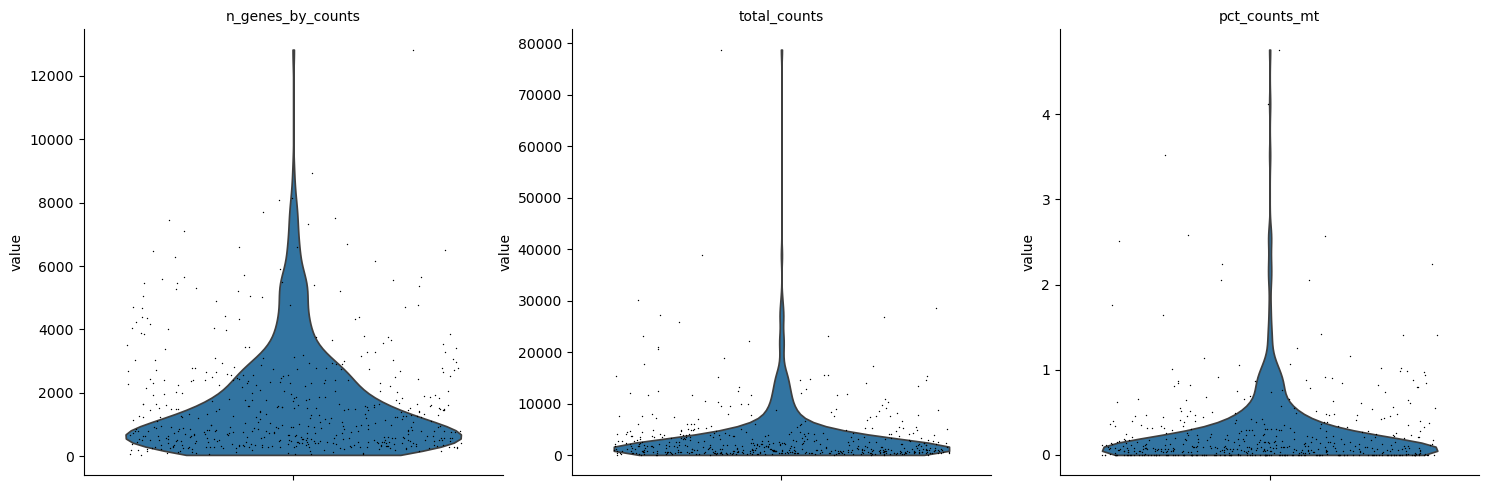

In [182]:
import scanpy as sc
import matplotlib.pyplot as plt

save_path = 'QC_RNA_before_filtration.pdf'
sc.pl.violin(rna_core, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save=save_path)

In [183]:
#Droublet analysis 
#conda install scikit-image=0.24.0 --no-channel-priority
new_core = sc.pp.scrublet(rna_core, adata_sim=None, batch_key=None, sim_doublet_ratio=2.0, expected_doublet_rate=0.05, stdev_doublet_rate=0.02, synthetic_doublet_umi_subsampling=1.0, knn_dist_metric='euclidean', normalize_variance=True, log_transform=False, mean_center=True, n_prin_comps=30, use_approx_neighbors=None, get_doublet_neighbor_parents=False, n_neighbors=None, threshold=None, verbose=True, copy=True, random_state=0)
new_core.obs['predicted_doublet']
percentage_true = (new_core.obs['predicted_doublet'].sum() / len(new_core.obs['predicted_doublet'])) * 100
new_core.obs['predicted_doublet'].sum() 
percentage_true

#if you do not specify a value for the threshold parameter (i.e., you set it to None), Scrublet will automatically determine an appropriate threshold.
#The method used is based on analyzing the distribution of the doublet_scores_sim_ (the simulated doublet scores) histogram.

3.861003861003861

In [184]:
# Count True and False values in 'predicted_doublet'
true_count = new_core.obs['predicted_doublet'].sum()  # Counts True values
false_count = (~new_core.obs['predicted_doublet']).sum()  # Counts False values

print(f"True count: {true_count}")
print(f"False count: {false_count}")


True count: 20
False count: 498


In [185]:
# Check for unique values in 'predicted_doublet'
unique_values = new_core.obs['predicted_doublet'].unique()

# Display unique values
print("Unique values in 'predicted_doublet':", unique_values)


Unique values in 'predicted_doublet': [False  True]


In [186]:
# Count the total number of entries in 'predicted_doublet'
total_count = new_core.obs['predicted_doublet'].count()

# Count the number of True values in 'predicted_doublet'
true_count = new_core.obs['predicted_doublet'].sum()

# Calculate the proportion of True values
true_proportion = true_count / total_count if total_count > 0 else 0

# Display the results
print(f"Total entries: {total_count}")
print(f"Number of True values: {true_count}")
print(f"Proportion of True values: {true_proportion:.2%}")


Total entries: 518
Number of True values: 20
Proportion of True values: 3.86%


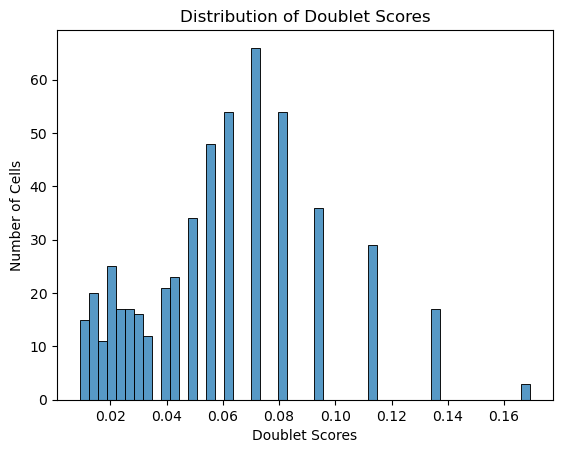

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns

# Access doublet scores
doublet_scores = new_core.obs['doublet_score']

# Plot histogram using seaborn for better aesthetics (or use plt.hist)
sns.histplot(doublet_scores, bins=50, kde=False)
plt.xlabel('Doublet Scores')
plt.ylabel('Number of Cells')
plt.title('Distribution of Doublet Scores')
plt.show()

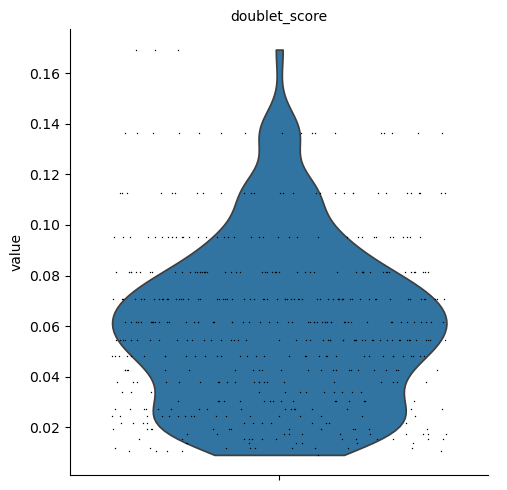

In [188]:
sc.pl.violin(new_core, ['doublet_score'], jitter=0.4, multi_panel=True, save=save_path)

In [170]:
## Filtration 

In [189]:
mu.pp.filter_obs(rna_core, 'n_genes_by_counts', lambda x: (x >= 300))
#The number of genes with at least 1 count in a cell. Calculated for all cells.

In [190]:
mu.pp.filter_obs(rna_core, 'pct_counts_mt', lambda x: x < 5)

In [191]:
rna_core

AnnData object with n_obs × n_vars = 464 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [196]:
# Initialize the dictionary to store all results
metrics = {}

# QC metrics
metrics["rna_n_genes_by_counts_top"] = None
metrics["rna_n_genes_by_counts_bottom"] = 300
metrics["rna_total_counts_top"] = None
metrics["rna_total_counts_bottom"] = None
metrics["rna_pct_counts_mt"] = 5

# Print QC metrics section
print("QC metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")

# Part 1: RNA Metrics
metrics["rna_core_min_total_counts"] = rna_core.obs['total_counts'].min()
metrics["rna_core_mean_total_counts"] = rna_core.obs['total_counts'].mean()
metrics["rna_core_max_total_counts"] = rna_core.obs['total_counts'].max()

metrics["rna_core_min_n_genes_by_counts"] = rna_core.obs['n_genes_by_counts'].min()
metrics["rna_core_mean_n_genes_by_counts"] = rna_core.obs['n_genes_by_counts'].mean()
metrics["rna_core_max_n_genes_by_counts"] = rna_core.obs['n_genes_by_counts'].max()

# Print RNA Metrics results
print("\nQC Results:")
for key, value in metrics.items():
    if key.startswith("rna_core"):
        print(f"{key}: {value}")

# Part 2: Doublet Analysis
# Count the total number of entries in 'predicted_doublet'
total_count = new_core.obs['predicted_doublet'].count()

# Count the number of True values in 'predicted_doublet'
true_count = new_core.obs['predicted_doublet'].sum()

# Calculate the proportion of True values
true_proportion = true_count / total_count if total_count > 0 else 0

# Add doublet analysis results to metrics
metrics["doublet_total_entries"] = total_count
metrics["doublet_true_count"] = true_count
metrics["doublet_true_proportion"] = f"{true_proportion:.2%}"

# Print doublet analysis results
print("\nDoublet Analysis Results:")
print(f"Total entries in 'predicted_doublet': {total_count}")
print(f"Number of True values: {true_count}")
print(f"Proportion of True values: {true_proportion:.2%}")

# Save the results to a file
file_path = "QC_filtration_metrics.txt"

with open(file_path, 'w') as file:
    # Write QC metrics
    file.write("QC metrics:\n")
    for key, value in metrics.items():
        if key.startswith("rna_") and not key.startswith("rna_core"):
            file.write(f"{key}: {value}\n")
    file.write("\n")
    
    # Write RNA metrics
    file.write("QC Results:\n")
    for key, value in metrics.items():
        if key.startswith("rna_core"):
            file.write(f"{key}: {value}\n")
    file.write("\n")
    
    # Write doublet analysis results
    file.write("Doublet Analysis Results:\n")
    file.write(f"Total entries in 'predicted_doublet': {total_count}\n")
    file.write(f"Number of True values: {true_count}\n")
    file.write(f"Proportion of True values: {true_proportion:.2%}\n")

print(f"Metrics have been written to {file_path}")


QC metrics:
rna_n_genes_by_counts_top: None
rna_n_genes_by_counts_bottom: 300
rna_total_counts_top: None
rna_total_counts_bottom: None
rna_pct_counts_mt: 5

QC Results:
rna_core_min_total_counts: 345.0
rna_core_mean_total_counts: 3754.019287109375
rna_core_max_total_counts: 78727.0
rna_core_min_n_genes_by_counts: 304
rna_core_mean_n_genes_by_counts: 1847.7004310344828
rna_core_max_n_genes_by_counts: 12821

Doublet Analysis Results:
Total entries in 'predicted_doublet': 518
Number of True values: 20
Proportion of True values: 3.86%
Metrics have been written to QC_filtration_metrics.txt


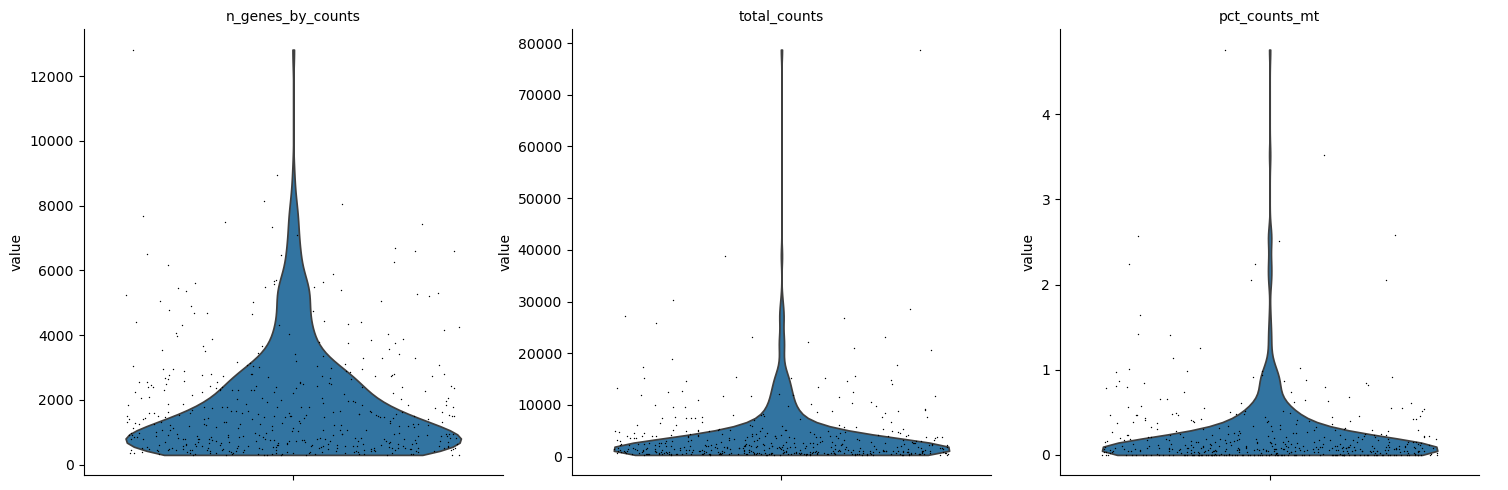

In [197]:
save_path = 'QC_RNA_after_filtration.pdf'
sc.pl.violin(rna_core, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save=save_path)


In [198]:
rna_core

AnnData object with n_obs × n_vars = 464 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [199]:
rna_core = rna_core[:, ~rna_core.var['mt'].values] #remove mt genes

In [200]:
rna_core

View of AnnData object with n_obs × n_vars = 464 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [203]:
sc.pp.normalize_total(rna_core, target_sum=1e4)

In [204]:
sc.pp.log1p(rna_core)

In [215]:
sc.pp.highly_variable_genes(rna_core, min_mean=0.02, max_mean=4, min_disp=0.5)

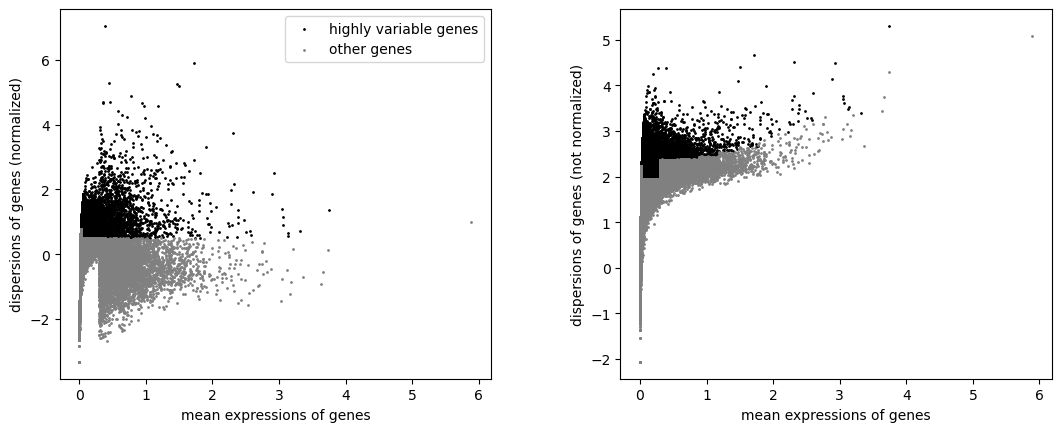

In [216]:
save_path = '.pdf'

sc.pl.highly_variable_genes(rna_core, save=save_path)


In [217]:
rna_core.raw = rna_core #QQQQ
sc.pp.scale(rna_core, max_value=10)

In [45]:
rna_core

AnnData object with n_obs × n_vars = 464 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [51]:
BASE_DIR

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core'

In [50]:
rna_core.write(f'{BASE_DIR}/BTROHT01_4_core_rna_QcFiltered.h5ad')

# Read QC Filtered Data

In [10]:
rna_core = sc.read(f'{BASE_DIR}/BTROHT01_4_core_rna_QcFiltered.h5ad')

In [11]:
rna_core

AnnData object with n_obs × n_vars = 464 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

In [12]:
# IMPORTANT, in the ## QC for the perimarginal, there are 18 hidden cells for QC for the perimarginal, I transfered to raw. 

## PCA and UMAP 

In [13]:
sc.tl.pca(rna_core, svd_solver='arpack', use_highly_variable=False)

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


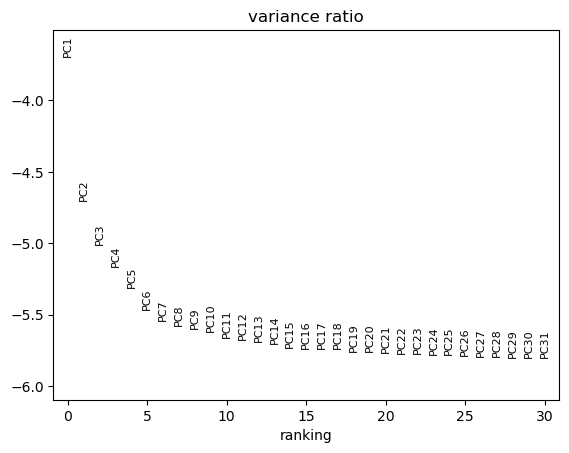

In [14]:
save_path = '.pdf'
sc.pl.pca_variance_ratio(rna_core, log=True, save=save_path)

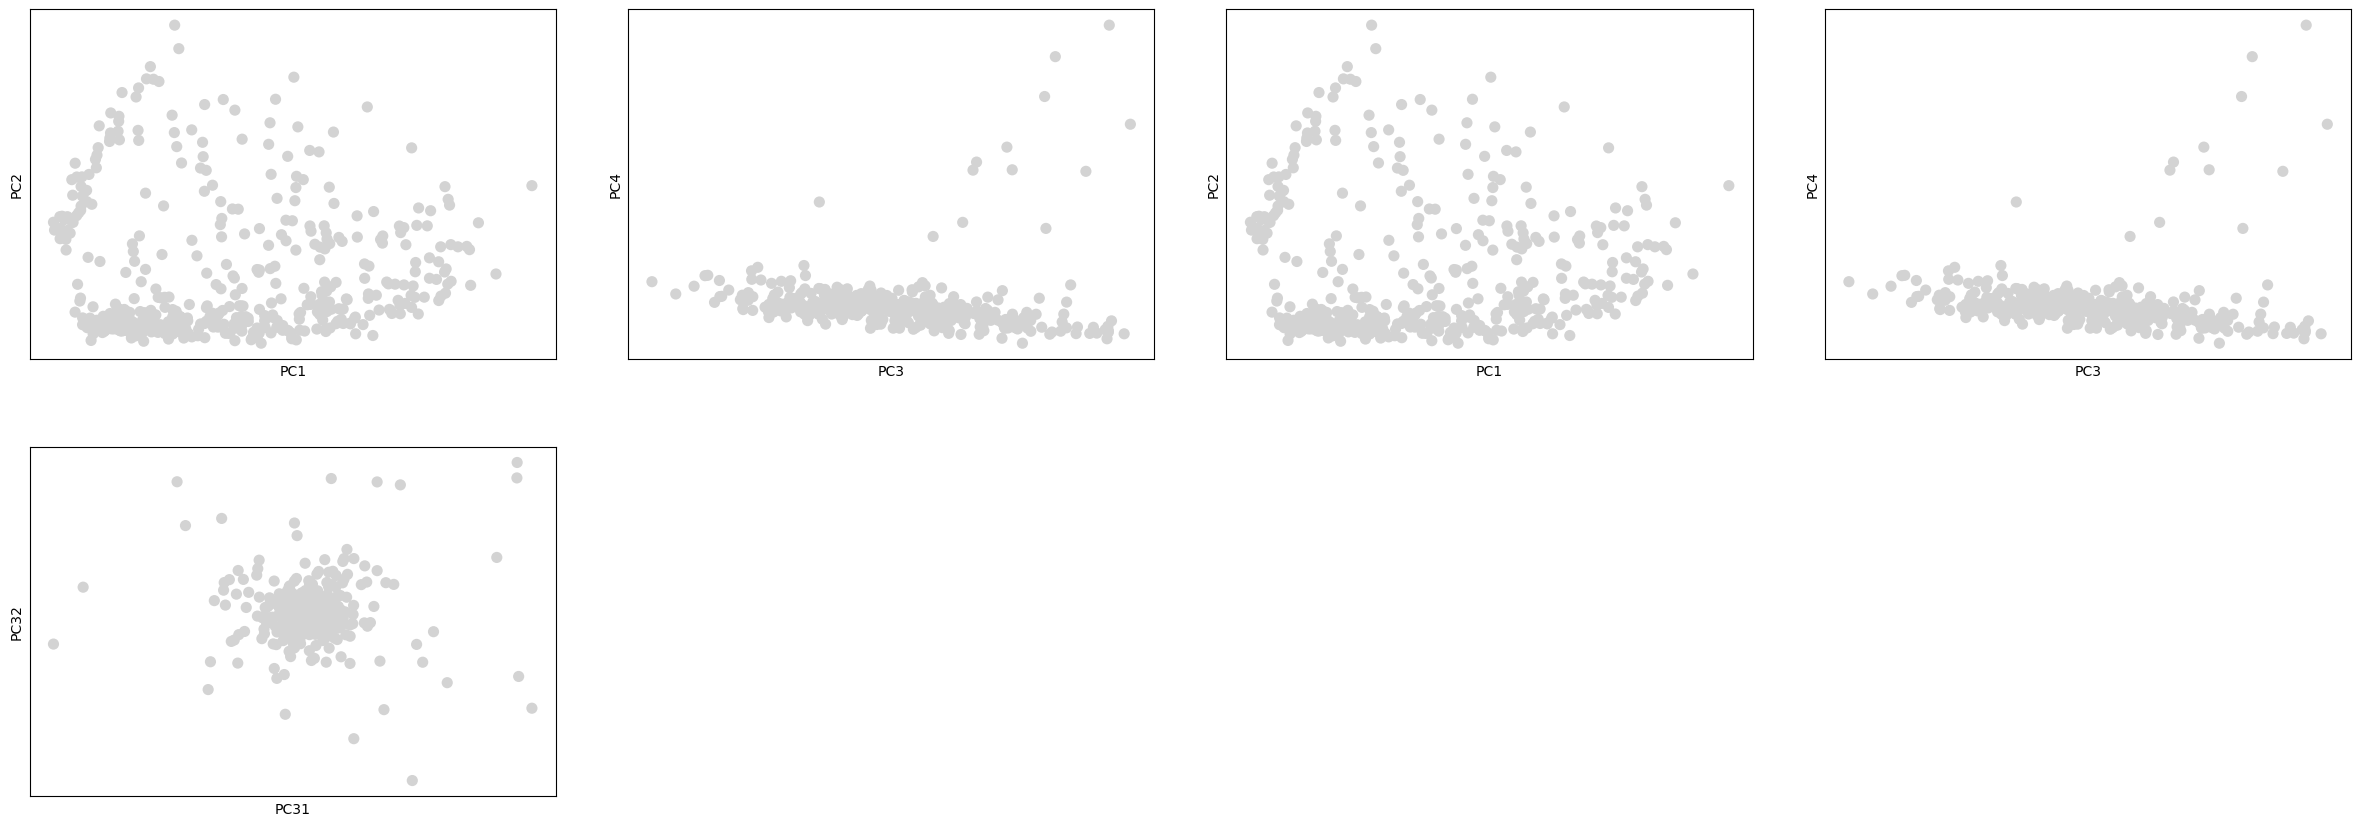

In [15]:
sc.pl.pca(
    rna_core,
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3),(30,31)]
)

In [16]:
# Assuming rna_core is your AnnData object
sc.pp.neighbors(rna_core, n_neighbors=10)  # Calculate neighbors first
sc.tl.umap(rna_core,min_dist=0.15)  # Calculate UMAP

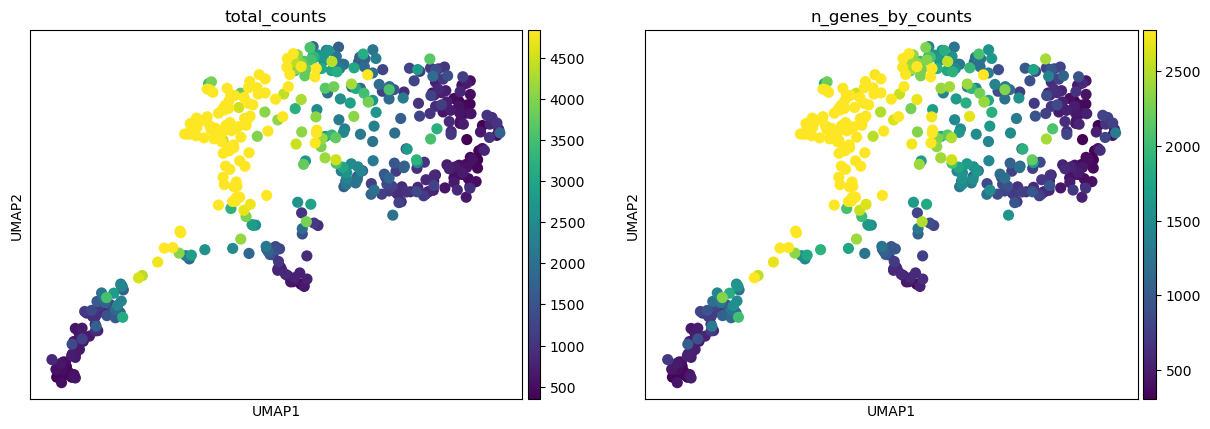

In [17]:
sc.pl.umap(rna_core,color=['total_counts', 'n_genes_by_counts'],vmax='p80') #vmax='p80'

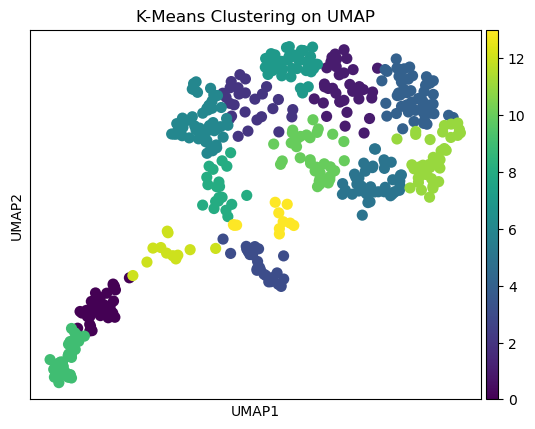

In [18]:
import scanpy as sc
import numpy as np

# Assuming rna_core is your AnnData object
sc.pp.neighbors(rna_core, n_neighbors=10)  # Calculate neighbors first
sc.tl.umap(rna_core,min_dist=0.15)  # Calculate UMAP

# Perform K-Means clustering
from sklearn.cluster import KMeans

# Define the number of clusters (adjust as needed)
num_clusters = 14

# Fit K-Means on the UMAP representation
kmeans = KMeans(n_clusters=num_clusters, random_state=11)
rna_core.obs['kmeans_cluster'] = kmeans.fit_predict(rna_core.obsm['X_umap'])

# Visualize the results
sc.pl.umap(rna_core, color='kmeans_cluster', title='K-Means Clustering on UMAP', legend_loc='on data')

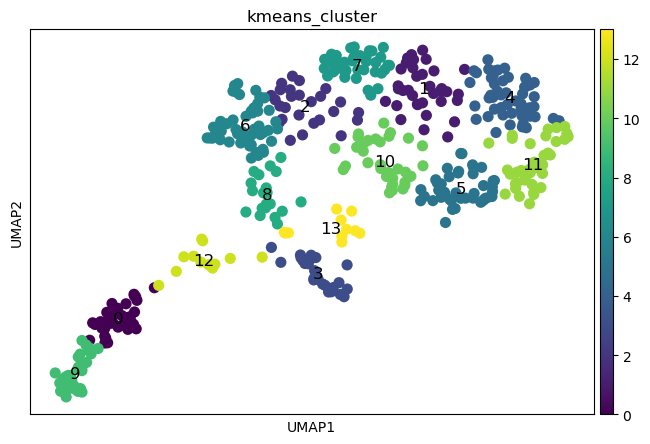

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

# Assume 'rna_core' is your AnnData object

# Create a figure with one plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # Adjust the figsize as needed

# Group to plot
group = 'kmeans_cluster'

# Plot the UMAP for the specified group
sc.pl.umap(rna_core, color=group, show=False, ax=ax)

# Add cluster numbers as annotations
for cluster in rna_core.obs[group].unique():
    # Get the UMAP coordinates for the current cluster
    cluster_data = rna_core[rna_core.obs[group] == cluster]
    
    # Calculate the mean UMAP coordinates for the cluster
    mean_x = cluster_data.obsm['X_umap'][:, 0].mean()
    mean_y = cluster_data.obsm['X_umap'][:, 1].mean()
    
    # Add the cluster label at the mean coordinates
    ax.text(mean_x, mean_y, str(cluster), fontsize=12, ha='center', va='center', color='black')

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.7, hspace=0.3)

# Display the plot
plt.show()

# Save the figure
save_path_png = 'figures/UMAP_BTROHT01_Kmeans_clustering_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT01_Kmeans_clustering_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box

# Close the figure to free up memory
plt.close(fig)


In [20]:
sc.tl.leiden(rna_core, resolution=3, random_state=11)

/tmp/ipykernel_2542602/3214373891.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna_core, resolution=3, random_state=11)


In [21]:
#sc.pp.neighbors(rna_core, n_neighbors=10, n_pcs=25, ) #1 #1=10
#sc.pp.neighbors(rna_core, n_neighbors=20, n_pcs=25, ) #0

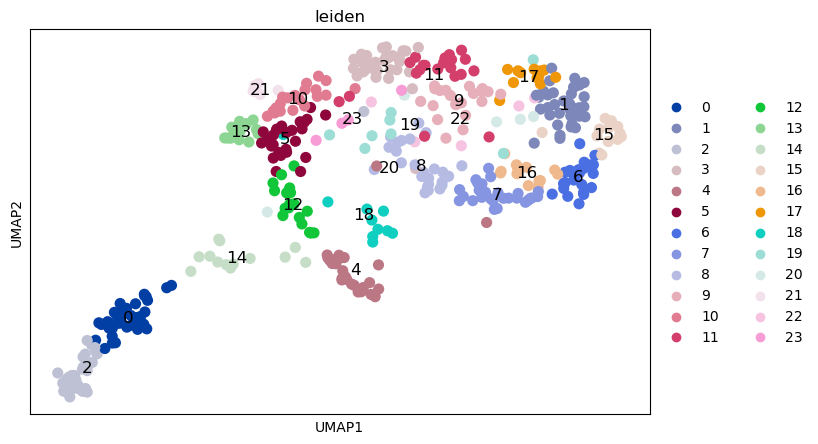

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

# Assume 'rna_core' is your AnnData object

# Create a figure with one plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # Adjust the figsize as needed

# Group to plot
group = 'leiden'

# Plot the UMAP for the specified group
sc.pl.umap(rna_core, color=group, show=False, ax=ax)

# Add cluster numbers as annotations
for cluster in rna_core.obs[group].unique():
    # Get the UMAP coordinates for the current cluster
    cluster_data = rna_core[rna_core.obs[group] == cluster]
    
    # Calculate the mean UMAP coordinates for the cluster
    mean_x = cluster_data.obsm['X_umap'][:, 0].mean()
    mean_y = cluster_data.obsm['X_umap'][:, 1].mean()
    
    # Add the cluster label at the mean coordinates
    ax.text(mean_x, mean_y, str(cluster), fontsize=12, ha='center', va='center', color='black')

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.7, hspace=0.3)

# Display the plot
plt.show()

# Save the figure
save_path_png = 'figures/UMAP_BTROHT01-core_leiden_clustering_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT01-core_leiden_clustering_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box

# Close the figure to free up memory
plt.close(fig)


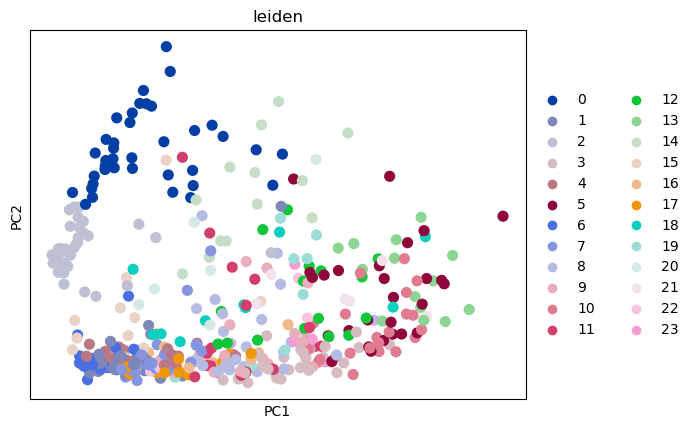

In [23]:
sc.pl.pca(
    rna_core,
    dimensions=[(0, 1)], color='leiden'
)

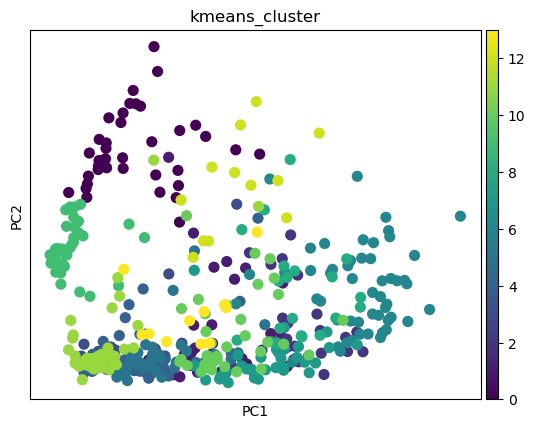

In [24]:
sc.pl.pca(
    rna_core,
    dimensions=[(0, 1)], color='kmeans_cluster'
)

In [25]:
rna_core

AnnData object with n_obs × n_vars = 464 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans_cluster', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Celltypist for Core

In [26]:
import celltypist
from celltypist import models
models.models_path= '/home/fatemeh.nasrabadi/ROVIGO/models_cell_typist/'

In [27]:
model = models.Model.load(model = 'Adult_Human_PrefrontalCortex.pkl')
predictions_adultcore = celltypist.annotate(rna_core, model = 'Adult_Human_PrefrontalCortex.pkl', majority_voting = True)

👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will use `.raw.X` instead
🔬 Input data has 464 cells and 36588 genes
🔗 Matching reference genes in the model
🧬 3652 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [28]:
rna_core.obs['cell_typist_majority_voting_Adult_Human_PrefrontalCortex']=predictions_adultcore.predicted_labels['majority_voting']
rna_core.obs['cell_typist_predicted_labels_Adult_Human_PrefrontalCortex']=predictions_adultcore.predicted_labels['predicted_labels']
rna_core.obs["celltypist_conf_score_Adult_Human_PrefrontalCortex"] = predictions_adultcore.to_adata().obs.loc[
    rna_core.obs.index, "conf_score"
]

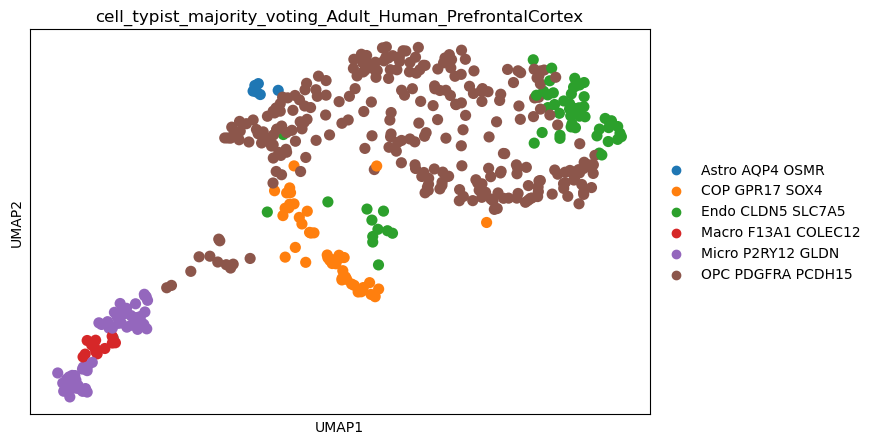

In [29]:
# Assume 'rna_combined' is your AnnData object

# Create a figure with one plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # Adjust the figsize as needed

# Group to plot
group = 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex'

# Plot the UMAP for the specified group
sc.pl.umap(rna_core, color=group, show=False, ax=ax)

# Adjust layout and spacing (not really necessary for a single plot, but keeping it in case you expand)
plt.subplots_adjust(wspace=0.7, hspace=0.3)

# Display the plot
plt.show()

# Save the figure
save_path_png = 'figures/UMAP_BTROHT01-core_celltypist_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT01-core_celltypist_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box

# Close the figure to free up memory
plt.close(fig)

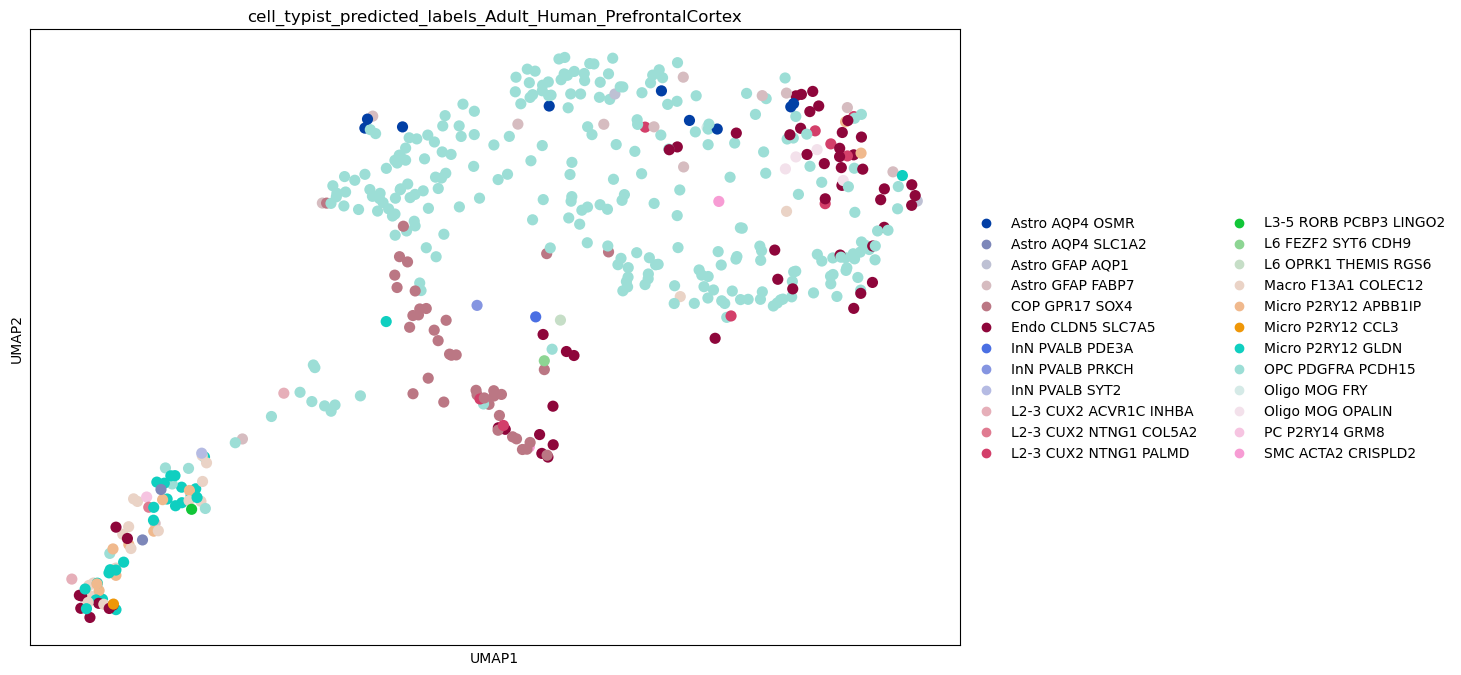

In [30]:
# Assume 'rna_combined' is your AnnData object

# Create a figure with one plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))  # Adjust the figsize as needed

# Group to plot
group = 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex'

# Plot the UMAP for the specified group
sc.pl.umap(rna_core, color=group, show=False, ax=ax)

# Adjust layout and spacing (not really necessary for a single plot, but keeping it in case you expand)
plt.subplots_adjust(wspace=0.7, hspace=0.3)

# Display the plot
plt.show()

# Save the figure
save_path = 'figures/UMAP_BTROHT01-core_celltypist_plots.jpg'
fig.savefig(save_path)

# Close the figure to free up memory
plt.close(fig)


In [31]:
#sc.tl.dendrogram(rna, groupby='celltype',)
sc.tl.rank_genes_groups(rna_core, groupby='cell_typist_majority_voting_Adult_Human_PrefrontalCortex', method='wilcoxon')
 
result = rna_core.uns['rank_genes_groups']
gene_names=[]
gene_dict={}
for type in rna_core.obs['cell_typist_majority_voting_Adult_Human_PrefrontalCortex'].unique():
    if type in result['names'].dtype.names:
        top_genes = result['names'][type][:5]
        gene_names.extend(top_genes)
        gene_dict[type]=top_genes
gene_dict

{'OPC PDGFRA PCDH15': array(['LRRTM4', 'NRXN1', 'SOX2-OT', 'LRP1B', 'ADGRB3'], dtype=object),
 'Endo CLDN5 SLC7A5': array(['GFAP', 'CLU', 'RPL41', 'CCNL2', 'SIPA1L1'], dtype=object),
 'Astro AQP4 OSMR': array(['TPD52L1', 'GPC5', 'MGST1', 'NRG3', 'CADPS'], dtype=object),
 'COP GPR17 SOX4': array(['AC009041.2', 'TNS3', 'OPCML', 'AL359091.1', 'PKP4'], dtype=object),
 'Micro P2RY12 GLDN': array(['SLC11A1', 'PLXDC2', 'DOCK4', 'BMP2K', 'MEF2A'], dtype=object),
 'Macro F13A1 COLEC12': array(['SLC11A1', 'PLXDC2', 'ST6GAL1', 'RHBDF2', 'DOCK4'], dtype=object)}

In [32]:
#sc.tl.dendrogram(rna, groupby='celltype',)
sc.tl.rank_genes_groups(rna_core, groupby='leiden', method='wilcoxon')
 
result = rna_core.uns['rank_genes_groups']
gene_names=[]
gene_dict={}
for type in rna_core.obs['leiden'].unique():
    if type in result['names'].dtype.names:
        top_genes = result['names'][type][:5]
        gene_names.extend(top_genes)
        gene_dict[type]=top_genes
gene_dict

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecel

{'10': array(['ID4', 'KIT', 'KCNQ5', 'SLC4A4', 'EVA1C'], dtype=object),
 '3': array(['DCLK2', 'EEPD1', 'GLIS3', 'NFIA', 'FADS2'], dtype=object),
 '6': array(['SOX2-OT', 'NOVA1', 'LHFPL3', 'LINC02283', 'PDGFRA'], dtype=object),
 '9': array(['GLIS3', 'DTNA', 'DCLK1', 'NFIA', 'SORBS1'], dtype=object),
 '18': array(['RBFOX1', 'PPP1R13B', 'DLGAP1', 'KCNIP4', 'RAB11FIP3'],
       dtype=object),
 '1': array(['GFAP', 'GOLGA8A', 'MALAT1', 'PLCG2', 'MIR99AHG'], dtype=object),
 '21': array(['TPD52L1', 'GPC5', 'MGST1', 'NRG3', 'CADPS'], dtype=object),
 '13': array(['UNC5C', 'CNTNAP4', 'SPOCK3', 'DLC1', 'ST18'], dtype=object),
 '4': array(['AC009041.2', 'TNS3', 'OPCML', 'AL359091.1', 'FYN'], dtype=object),
 '8': array(['FGF14', 'LINC02283', 'NRXN1', 'LHFPL3', 'AGAP1'], dtype=object),
 '16': array(['LHFPL3', 'SOX2-OT', 'UHRF1', 'CSMD2', 'AC004852.2'], dtype=object),
 '14': array(['LINC01374', 'SFMBT2', 'SH3RF3', 'NAV3', 'PLXDC2'], dtype=object),
 '2': array(['SLC11A1', 'PLXDC2', 'BMP2K', 'MEF2A', 'S

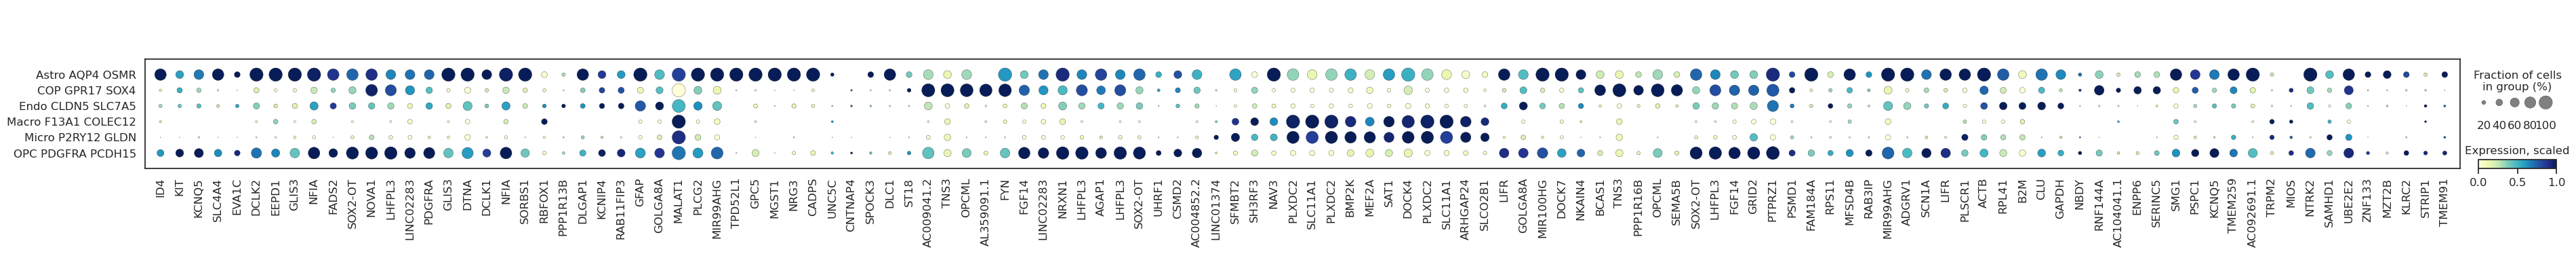

In [33]:
sns.set_theme(style="white", palette="pastel", font_scale = 1.2, rc={"lines.linewidth": 0.5})
save_path='_rna_marker_genes.pdf'

sc.pl.dotplot(rna_core, var_names=gene_names, 
              groupby='cell_typist_majority_voting_Adult_Human_PrefrontalCortex',colorbar_title='Expression, scaled',
              #categories_order=[ 'Brain neurons', 'mOli', 'Microglia'  ,'Astrocytes', 'Tumor cells' ], 
              standard_scale='var', 
              cmap='YlGnBu',  
              
              dendrogram=False,save=save_path)

## InferCNV

In [34]:
import infercnvpy as cnv
adata_add = cnv.datasets.maynard2020_3k()
adata_add.var.loc[:, ["ensg", "chromosome", "start", "end"]]
adata_add

AnnData object with n_obs × n_vars = 3000 × 55556
    obs: 'age', 'sex', 'sample', 'patient', 'cell_type'
    var: 'ensg', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [35]:
adata_add.obs

age     sex  sample    patient        cell_type
Run                                                         
SRR10796381   53  female  LT_S74      TH248       T cell CD4
SRR10787713   40  female  LT_S75      TH266       Macrophage
SRR10785570   56    male  LT_S28      TH185       T cell CD4
SRR10790048   69  female  LT_S65  TH238_NAT         Monocyte
SRR10782528   46  female  LT_S08      TH103  Epithelial cell
...          ...     ...     ...        ...              ...
SRR10782593   71  female  LT_S47      TH220       Fibroblast
SRR10789971   55    male  LT_S21      TH185  Epithelial cell
SRR10780468   62    male  LT_S58      TH179  Epithelial cell
SRR10779840   78  female  LT_S50      TH225              mDC
SRR10795768   63    male  LT_S57      TH226            other

[3000 rows x 5 columns]

In [36]:
adata_add.var

ensg   mito  n_cells_by_counts  mean_counts  \
symbol                                                                 
AL645933.5  ENSG00000288587.1  False               1854     1.613897   
AC010184.1  ENSG00000288585.1  False                310     0.412183   
AC023296.1  ENSG00000288580.1  False                103     0.196091   
AL117334.2  ENSG00000288577.1  False                176     0.087959   
AC107294.4  ENSG00000288576.1  False                  9     0.023121   
...                       ...    ...                ...          ...   
DOCK8-AS1   ENSG00000183784.7  False               1758     9.321348   
LIF-AS1     ENSG00000232530.1  False                265     0.545650   
AC093673.1  ENSG00000232533.1  False               3423    15.522471   
LINC00945   ENSG00000232539.1  False                 10     0.030850   
RPL36P19    ENSG00000232540.1  False                 12     0.008548   

            pct_dropout_by_counts   total_counts       n_counts chromosome  \
symbol                                                                       
AL645933.5              91.340091   34551.914062   34551.914062       chr6   
AC010184.1              98.552011    8824.419922    8824.419922       chr3   
AC023296.1              99.518894    4198.104004    4198.104004       chr8   
AL117334.2              99.177916    1883.123047    1883.123047      chr20   
AC107294.4              99.957962     495.000000     495.000000       chr3   
...                           ...            ...            ...        ...   
DOCK8-AS1               91.788500  199560.750000  199560.750000       chr9   
LIF-AS1                 98.762203   11681.813477   11681.813477      chr22   
AC093673.1              84.011397  332320.593750  332320.593750       chr7   
LINC00945               99.953291     660.473999     660.473999      chr21   
RPL36P19                99.943949     183.000000     183.000000      chr13   

                start        end            gene_id   gene_name  
symbol                                                           
AL645933.5   31400702   31463705  ENSG00000288587.1  AL645933.5  
AC010184.1  141449745  141456434  ENSG00000288585.1  AC010184.1  
AC023296.1    2923568    2926689  ENSG00000288580.1  AC023296.1  
AL117334.2    3406380    3410036  ENSG00000288577.1  AL117334.2  
AC107294.4  184778723  184780720  ENSG00000288576.1  AC107294.4  
...               ...        ...                ...         ...  
DOCK8-AS1      212824     215893  ENSG00000183784.7   DOCK8-AS1  
LIF-AS1      30239194   30240538  ENSG00000232530.1     LIF-AS1  
AC093673.1  143379692  143380495  ENSG00000232533.1  AC093673.1  
LINC00945    33057829   33064983  ENSG00000232539.1   LINC00945  
RPL36P19     43394525   43394825  ENSG00000232540.1    RPL36P19  

[55556 rows x 12 columns]

In [37]:
adata_inf=rna_core.raw.to_adata()
adata_inf.var['end']=adata_add.var.loc[:, ["end"]]
adata_inf.var['start']=adata_add.var.loc[:, ["start"]]
adata_inf.var['chromosome']=adata_add.var.loc[:, ["chromosome"]]
adata_inf.var.loc[:, [ "chromosome", "start", "end"]]

chromosome      start        end
MIR1302-2HG        chr1    29554.0    31109.0
FAM138A            chr1    34554.0    36081.0
OR4F5              chr1    65419.0    71585.0
AL627309.1         chr1    89295.0   133723.0
AL627309.3         chr1    89551.0    91105.0
...                 ...        ...        ...
AC141272.1   KI270728.1  1270984.0  1271271.0
AC023491.2   KI270731.1    10598.0    13001.0
AC007325.1   KI270734.1    72411.0    74814.0
AC007325.4   KI270734.1   131494.0   137392.0
AC007325.2   KI270734.1   138082.0   161852.0

[36588 rows x 3 columns]

In [38]:
rna_core.obs['cell_typist_majority_voting_Adult_Human_PrefrontalCortex'].value_counts()

cell_typist_majority_voting_Adult_Human_PrefrontalCortex
OPC PDGFRA PCDH15      282
Micro P2RY12 GLDN       59
Endo CLDN5 SLC7A5       58
COP GPR17 SOX4          47
Macro F13A1 COLEC12     12
Astro AQP4 OSMR          6
Name: count, dtype: int64

In [39]:
rna_core

AnnData object with n_obs × n_vars = 464 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans_cluster', 'leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'celltypist_conf_score_Adult_Human_PrefrontalCortex'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'over_clustering', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex_colors', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [40]:
cnv.tl.infercnv(
    adata_inf,
    reference_key="leiden",
    window_size=250,
    reference_cat=[
    '14','0','2'
    ]
)

  0%|          | 0/1 [00:00<?, ?it/s]

#11, 0 , 9 'kmeans_cluster'

cnv.tl.infercnv(
    adata_inf,
    reference_key='kmeans_cluster',
    window_size=250,
    reference_cat=[
       11,0,9
    ]
)


In [41]:
#######CHECK THE PARAMETERS######### 

In [42]:
cnv.tl.pca(adata_inf)
cnv.pp.neighbors(adata_inf, )
cnv.tl.leiden(adata_inf,resolution=1)
#cnv.tl.leiden(adata_inf,) #0
#resolution=2

for core 

sc.pp.neighbors(rna_core, n_neighbors=20, n_pcs=25, )
sc.tl.umap(rna_core, random_state=11) #default for min_dist=0.5

to : 
    
sc.pp.neighbors(rna_core, n_neighbors=10, n_pcs=25, )
sc.tl.umap(rna_core, random_state=11,min_dist=0.15)


In [43]:
cnv.tl.umap(adata_inf)
cnv.tl.cnv_score(adata_inf)

In [44]:
#два способа расчета cnv score для отдельной клетки
rna_core.obs['cnv_raw_l1'] = pd.DataFrame(np.ravel(np.mean(np.abs(adata_inf.obsm[f"X_cnv"]), axis=1)), 
                                     index=rna_core.obs.index)
rna_core.obs['cnv_raw_l2'] = pd.DataFrame(np.ravel(np.mean((adata_inf.obsm[f"X_cnv"]).power(2), axis=1))**.5, 
                                     index=rna_core.obs.index)
rna_core.obs['cnv_score']=adata_inf.obs['cnv_score']
rna_core.obs['cnv_leiden']=adata_inf.obs['cnv_leiden']

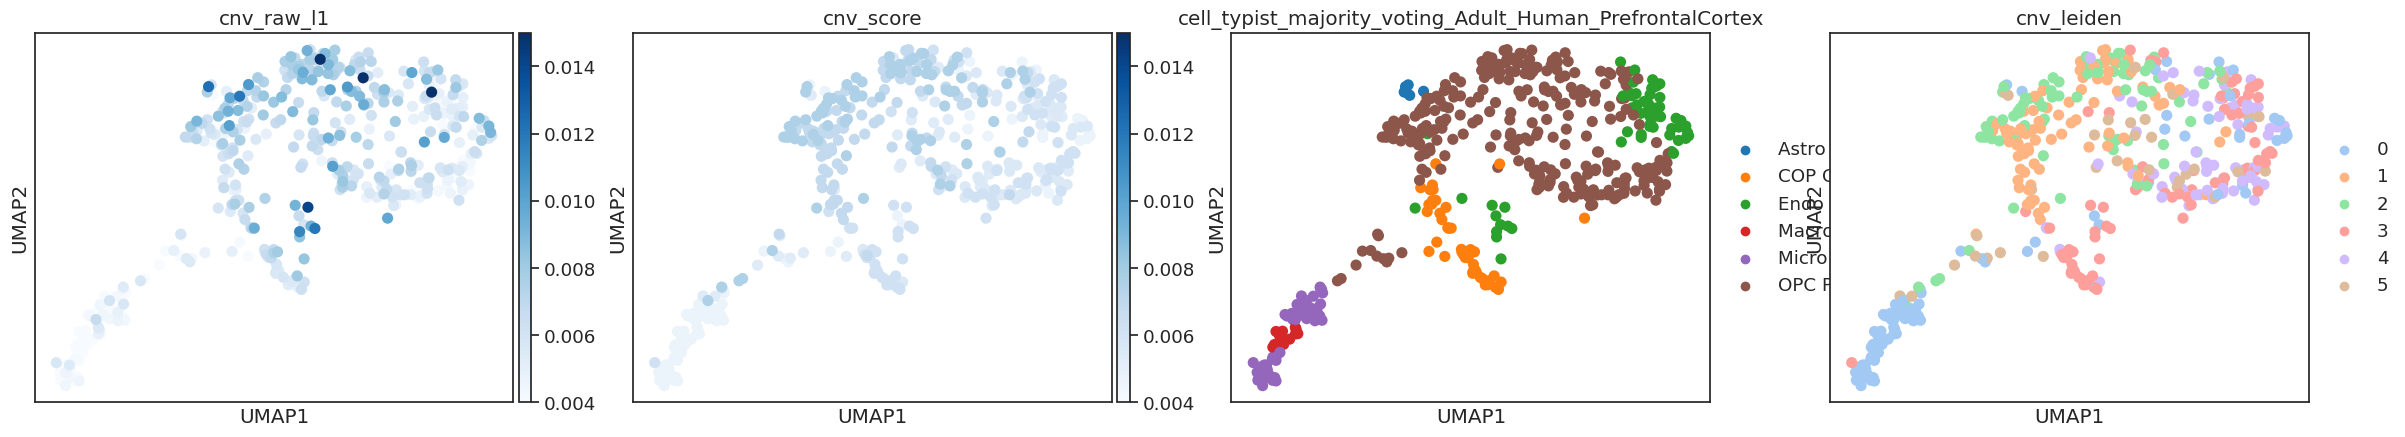

In [45]:
save_path='_rna_cnv.pdf'

sc.pl.umap(rna_core, ncols=4, color=['cnv_raw_l1', 'cnv_score', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cnv_leiden'], 
            color_map='Blues', vmax=0.015, vmin=0.004, save=save_path)

... storing 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex' as categorical


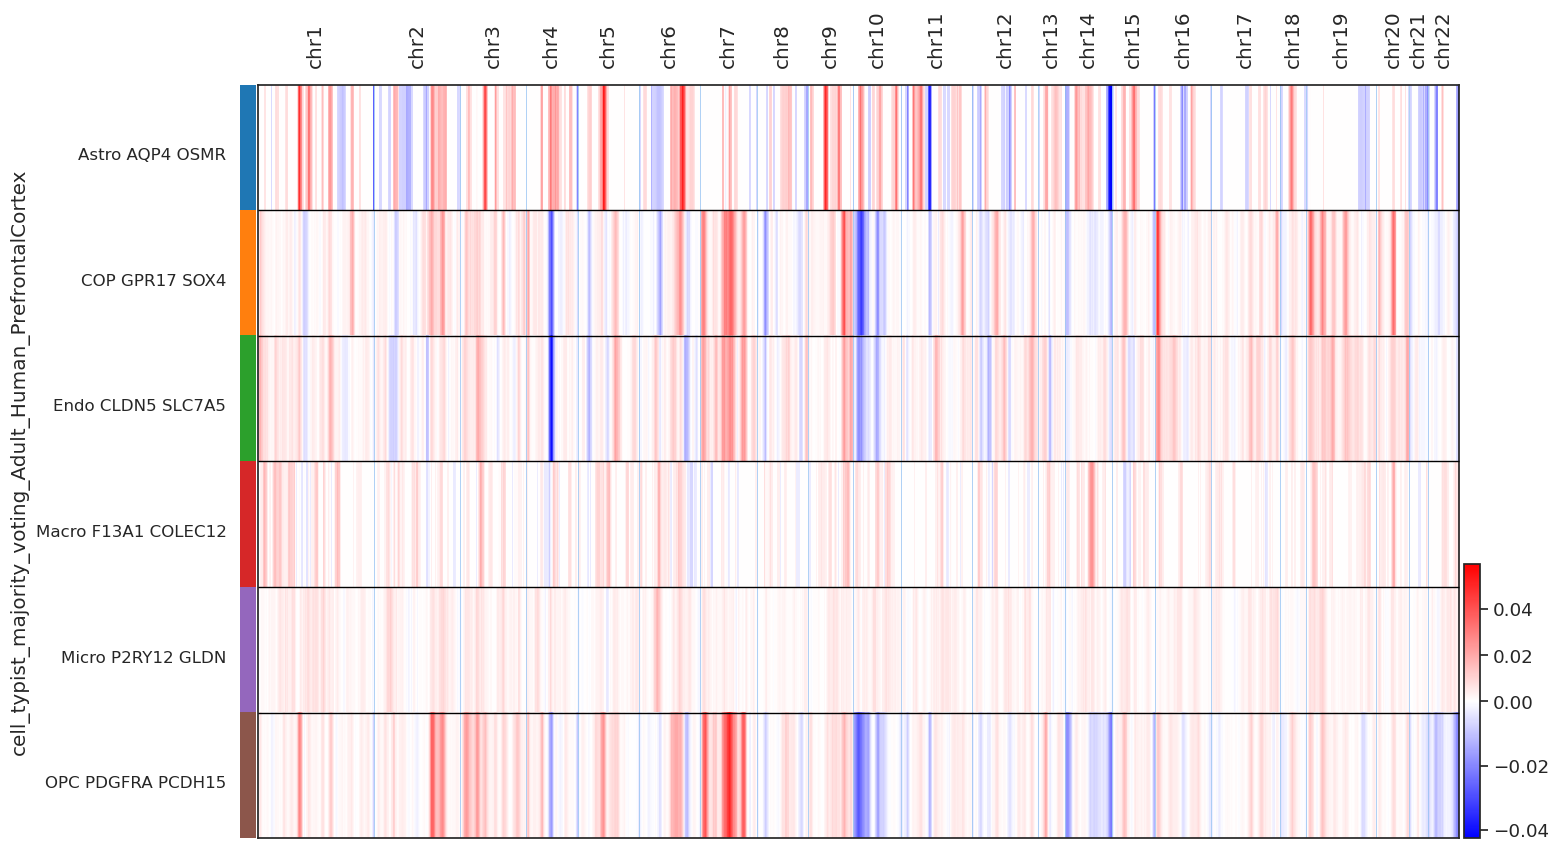

In [46]:

save_path = '_rna_cnv_heatmap_celltypist.pdf'
fig.savefig(save_path)

cnv.pl.chromosome_heatmap_summary(adata_inf, groupby="cell_typist_majority_voting_Adult_Human_PrefrontalCortex", save=save_path)

... storing 'leiden' as categorical


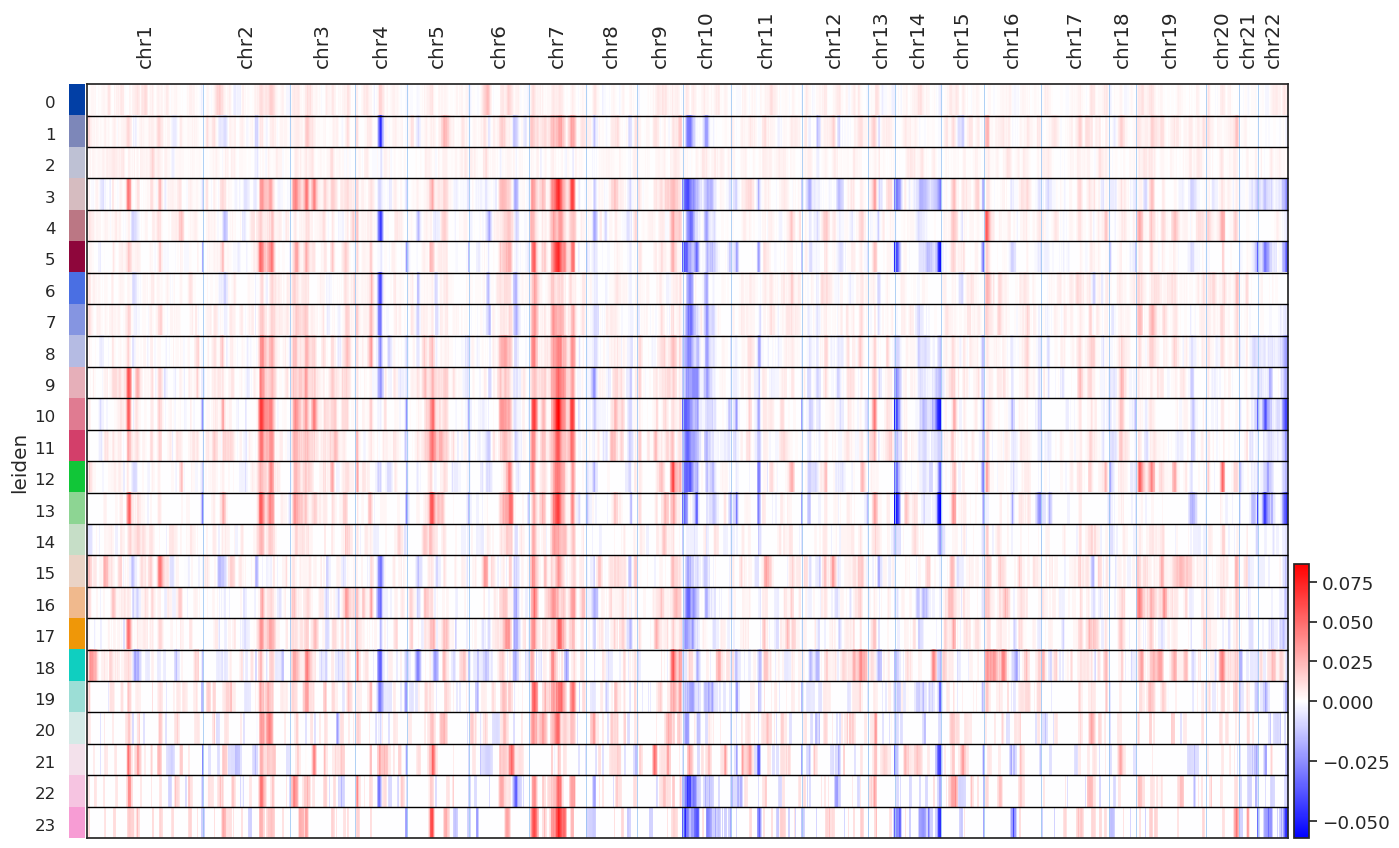

In [47]:
save_path = '_rna_cnv_heatmap_leiden.pdf'
fig.savefig(save_path)

cnv.pl.chromosome_heatmap_summary(adata_inf, groupby="leiden", save=save_path)

... storing 'cnv_leiden' as categorical


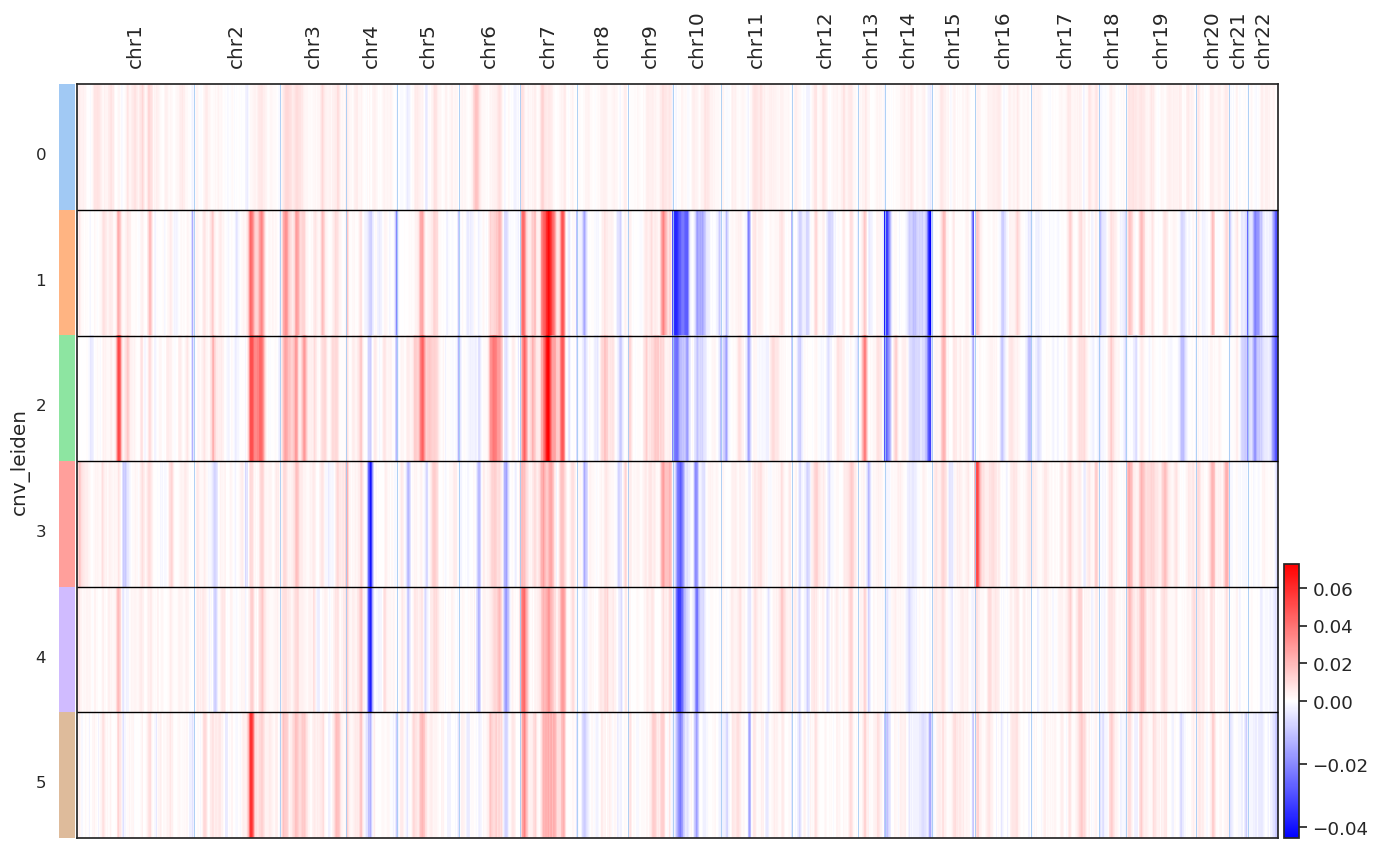

In [48]:
save_path='_rna_cnv_heatmap_cnv_leiden.pdf'
cnv.pl.chromosome_heatmap_summary(adata_inf, groupby="cnv_leiden", save=save_path)

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


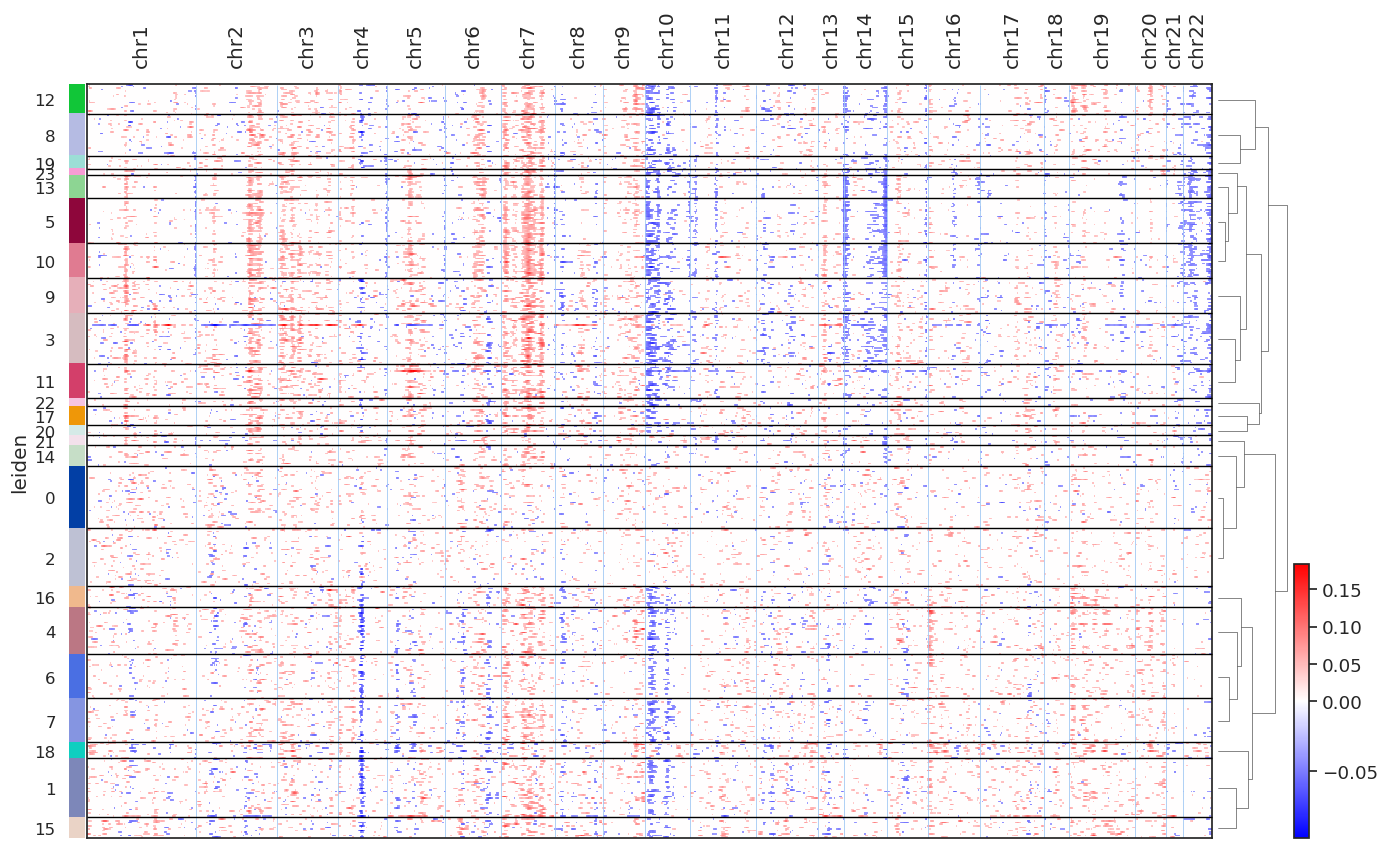

In [49]:
cnv.pl.chromosome_heatmap(adata_inf, groupby="leiden", dendrogram=True)

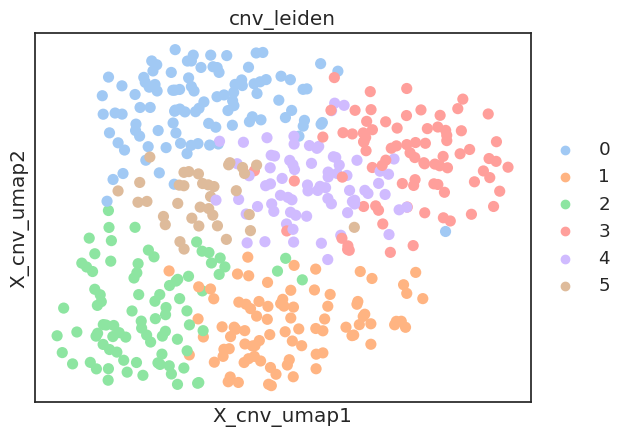

In [50]:
sc.pl.embedding(adata_inf, basis='X_cnv_umap', color=['cnv_leiden'])


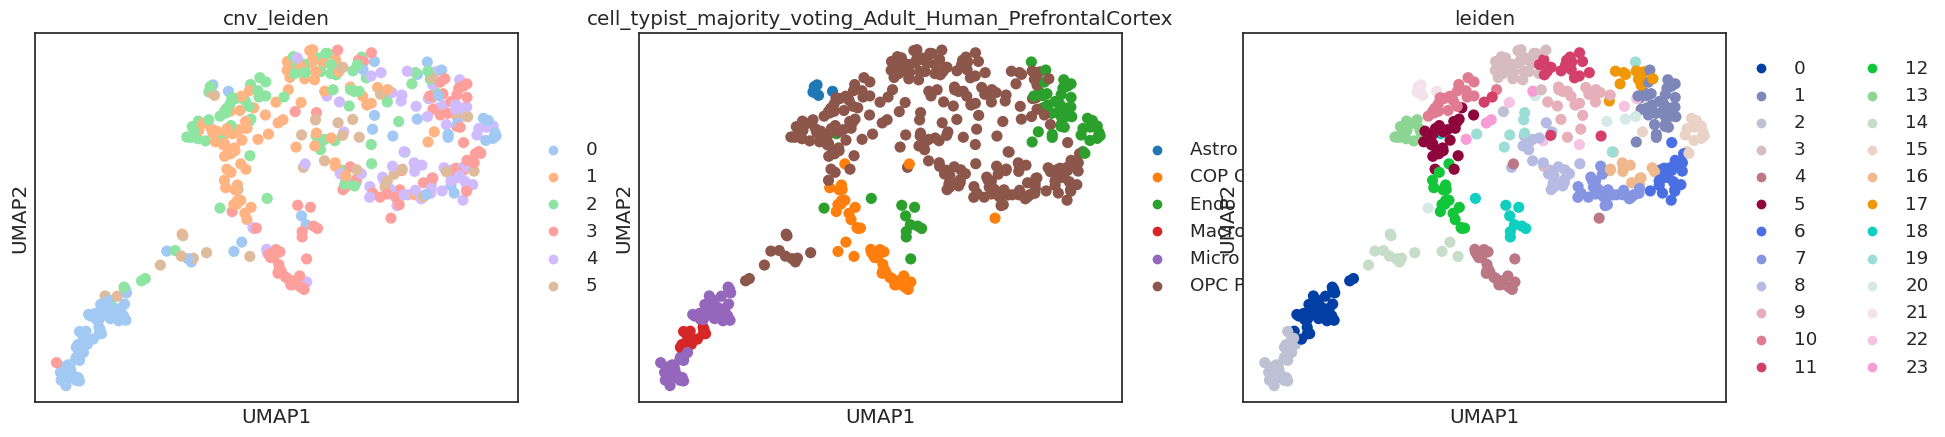

In [51]:
sc.pl.umap(adata_inf, color=['cnv_leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex','leiden'], vmax=20000)

rna_core.obs['celltype_new_label'] = rna_core.obs['leiden'].map({
    '14': 'Immune cells',
    '0': 'Immune cells',
    '7': 'Immune cells'
}).fillna('Tumor Cells')


#(Microglia, Macrophages)

In [52]:
rna_core.obs['celltype'] = rna_core.obs['kmeans_cluster'].map({
    12: 'Immune Cells',
    9: 'Immune Cells',
    0: 'Immune Cells'
}).fillna('Tumor Cells')


In [53]:
rna_core.obs['celltype_leiden'] = rna_core.obs['leiden'].map({
    '14': 'Immune Cells',
    '0': 'Immune Cells',
    '2': 'Immune Cells'
}).fillna('Tumor Cells')


... storing 'celltype' as categorical
... storing 'celltype_leiden' as categorical


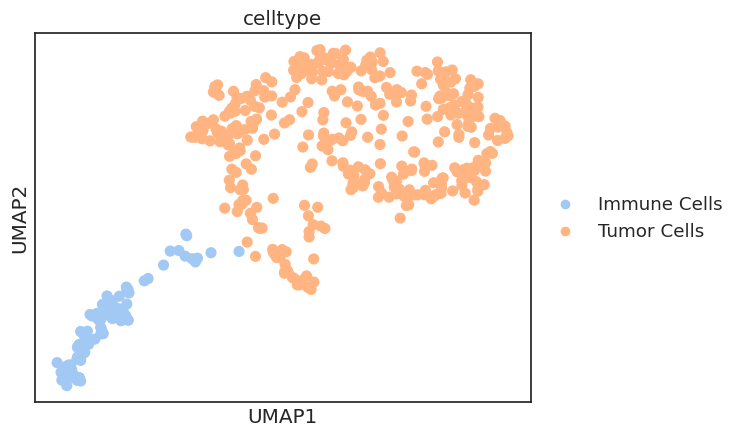

In [54]:
sc.pl.umap(rna_core, color=[ 'celltype'], vmax=20000)

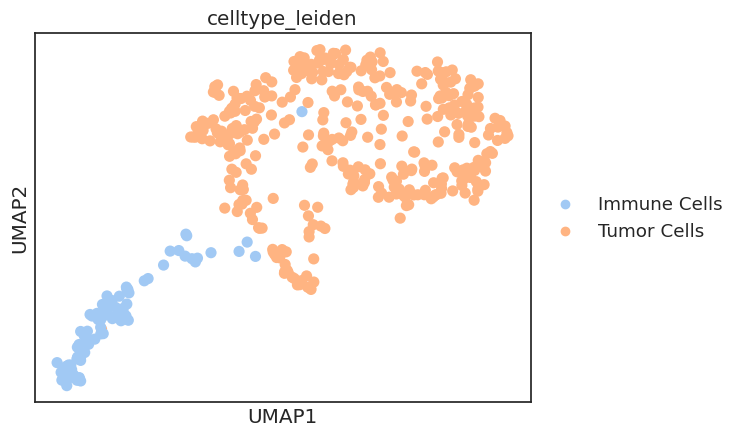

In [55]:
sc.pl.umap(rna_core, color=[ 'celltype_leiden'], vmax=20000)

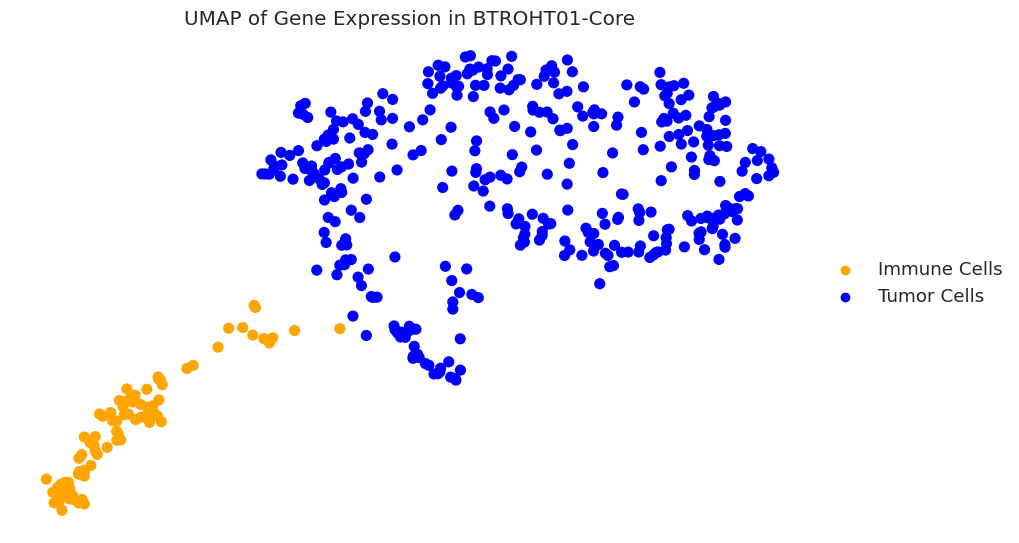

In [56]:
import scanpy as sc
import matplotlib.pyplot as plt

# Assuming `rna_core` is your AnnData object
# Define the color mapping for tumor and immune cells
colors = ['blue' if 'tumor' in cell_type.lower() else 'orange' if 'immune' in cell_type.lower() else 'gray' 
          for cell_type in rna_core.obs['celltype'].unique()]

# Create a color mapping dictionary to associate cell types with their respective colors
color_mapping = dict(zip(rna_core.obs['celltype_leiden'].unique(), colors))

# Create the UMAP plot
fig, ax = plt.subplots(figsize=(8, 5))  # Adjust the figsize as needed
sc.pl.umap(
    rna_core, 
    color='celltype', 
    vmax=20000, 
    palette=color_mapping,
    title='UMAP of Gene Expression in BTROHT01-Core',
    show=False,  # Avoid automatic display with a box around
    ax=ax
)


# Adjust layout to remove the box
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.axis('off')  # Hide the axis to avoid a box around the plot


# Save the figure
save_path_png = 'figures/UMAP_BTROHT01-core_leiden_annotated_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT01-core_leiden_annotated_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box



# Display the plot
plt.show()


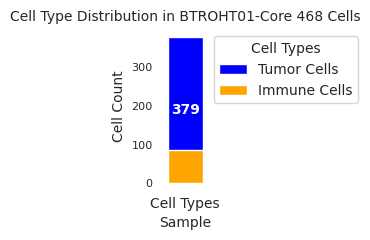

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `rna_core` is your AnnData object
celltype_counts = rna_core.obs['celltype'].value_counts()

# Define colors for each cell type
colors = []
for cell_type in celltype_counts.index:
    if "tumor" in cell_type.lower():
        colors.append("blue")
    elif "immune" in cell_type.lower():
        colors.append("orange")
    else:
        colors.append("gray")  # Use gray for any other cell types

# Plotting
plt.figure(figsize=(0.5, 2))
bars = plt.bar(
    x=['Cell Types'], 
    height=celltype_counts.values, 
    color=colors,
    label=celltype_counts.index
)

# Add labels and title with consistent font sizes
plt.xlabel("Sample", fontsize=10)
plt.ylabel("Cell Count", fontsize=10)
plt.title("Cell Type Distribution in BTROHT01-Core 468 Cells", fontsize=10)

# Add the number of tumor cells behind the bar (inside the bar)
tumor_cells = celltype_counts.get('Tumor Cells', 0)  # Ensure it handles missing data gracefully
plt.text(0, tumor_cells / 2, str(tumor_cells), ha='center', va='center', fontsize=10, color='white', weight='bold')

# Set legend with color references for each cell type
plt.legend(celltype_counts.index, title="Cell Types", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=10)

# Adjust y-axis tick labels
plt.yticks(fontsize=8)  # Adjusted y-tick font size

# Ensure consistent font size for all text
plt.xticks(fontsize=10)  # Match x-tick font size to others

# Remove the box around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Save the figure
save_path_png = 'figures/UMAP_BTROHT01-core_barplot_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT01-core_barplot_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box


plt.show()


... storing 'CNV Inference' as categorical


Unique cell types: ['Tumor Cells', 'Immune Cells']
Categories (2, object): ['Immune Cells', 'Tumor Cells']


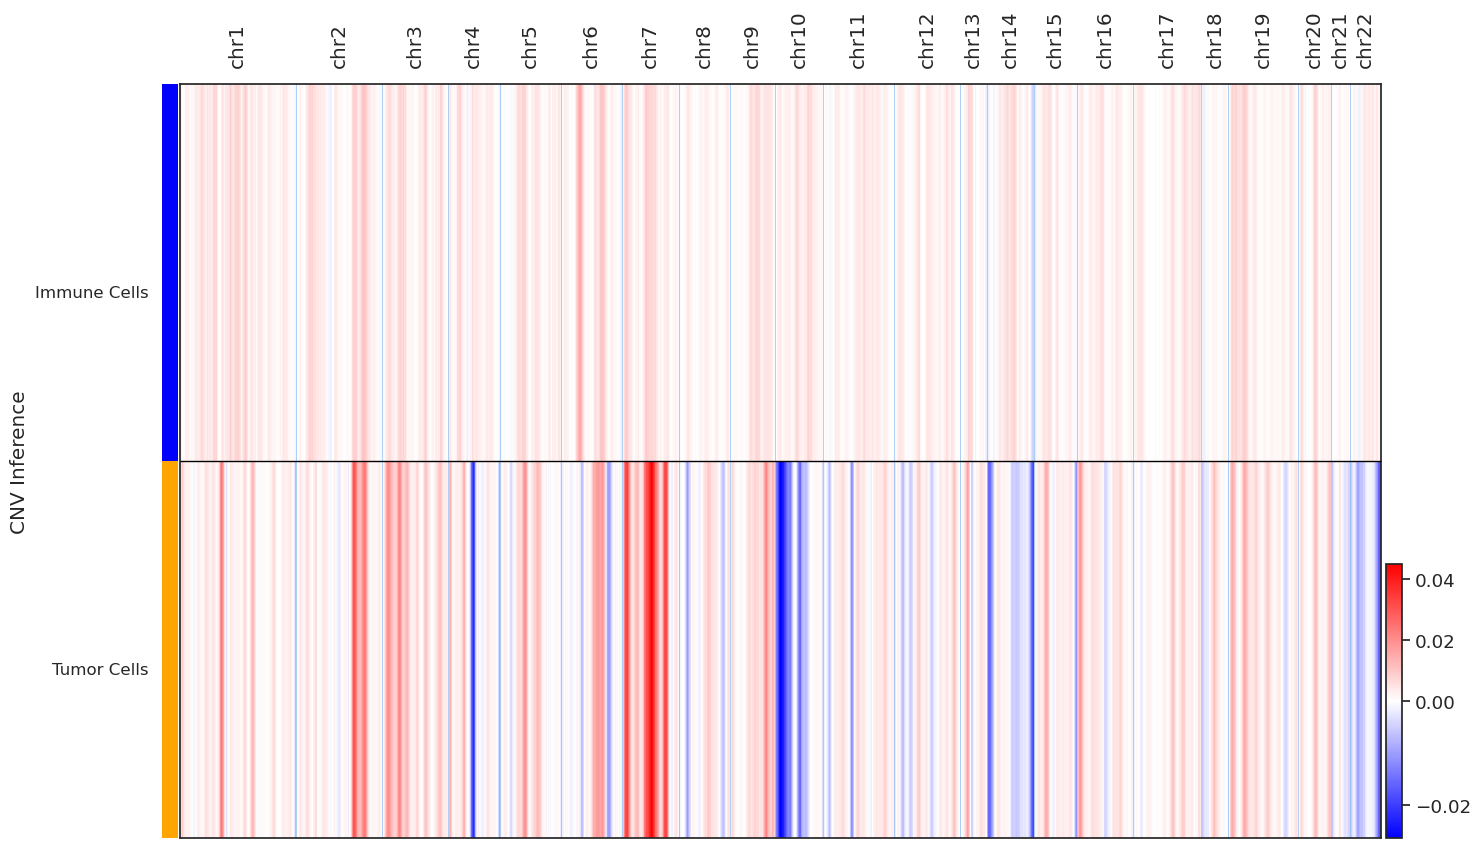

In [58]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

# Step 1: Define the custom color mapping
custom_colors = {
    'Immune Cells': 'Orange',  # Orange for immune cells
    'Tumor Cells': '#0000FF'   # Blue for tumor cells
}
default_color = '#808080'  # Grey for unspecified cell types

# Step 2: Map colors to the cell types
adata_inf.obs['CNV Inference'] = rna_core.obs['celltype']

# Step 3: Inspect unique cell types (optional for debugging)
print("Unique cell types:", adata_inf.obs['CNV Inference'].unique())

# Step 4: Update the CNV Inference palette in the AnnData object
adata_inf.uns['CNV Inference_colors'] = [
    to_hex(custom_colors.get(celltype, default_color)) for celltype in adata_inf.obs['CNV Inference'].unique()
]

# Step 5: Plot the heatmap and save the figure
save_path = '_rna_cnv_heatmap_celltype.pdf'
cnv.pl.chromosome_heatmap_summary(adata_inf, groupby="CNV Inference", save=save_path)

# Save the figure
save_path_png = 'figures/UMAP_BTROHT01-core_CNV_annotated_plots.jpg'
save_path_pdf = 'figures/UMAP_BTROHT01-core_CNV_annotated_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')  # Save as PNG with tight bounding box
fig.savefig(save_path_pdf, bbox_inches='tight')  # Save as PDF with tight bounding box

plt.show()


## Cell cycle Analysis

In [61]:
cell_cycle_genes = [x.strip() for x in open('/home/fatemeh.nasrabadi/files/cellcycle/regev_lab_cell_cycle_genes.txt')]

In [62]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in rna_core.var_names]

In [63]:
sc.tl.score_genes_cell_cycle(rna_core, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)

... storing 'phase' as categorical


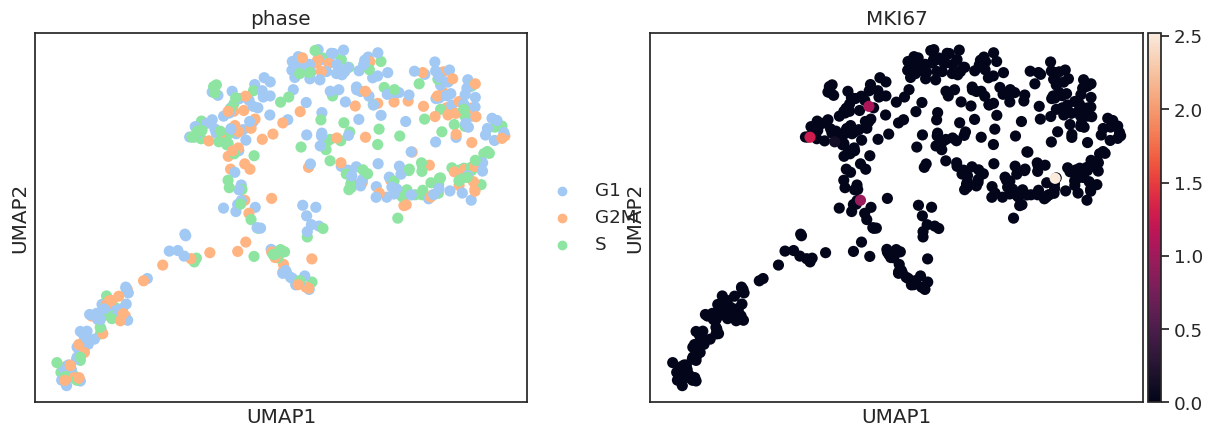

In [64]:
save_path='_rna_cellcycle.pdf'
sc.pl.umap(rna_core, color=['phase', 'MKI67'], save=save_path)

In [66]:
#sc.tl.dendrogram(rna_core, groupby='celltype_new_CNV_leiden',)
sc.tl.dendrogram(rna_core, groupby='celltype',)

In [67]:
adata_inf.obs['celltype'] = rna_core.obs['celltype']

In [68]:
adata_inf.obs['celltype']

AAACGGATCATTGCAA-1     Tumor Cells
AAACGGATCTCAATTC-1     Tumor Cells
AAAGCGGGTCATGCAA-1     Tumor Cells
AAAGCTTGTCACTCGC-1     Tumor Cells
AAAGCTTGTTAGGATT-1     Tumor Cells
                          ...     
TTTGCGGAGCCAGTAT-1     Tumor Cells
TTTGGTGCACACAATT-1     Tumor Cells
TTTGTCTAGGACGTAA-1    Immune Cells
TTTGTGGCAAGTCGCT-1     Tumor Cells
TTTGTTGGTGCTAGAC-1     Tumor Cells
Name: celltype, Length: 464, dtype: category
Categories (2, object): ['Immune Cells', 'Tumor Cells']

In [70]:
sc.tl.dendrogram(rna_core, groupby='celltype',)
sc.tl.rank_genes_groups(rna_core, groupby='celltype', method='wilcoxon')

result = rna_core.uns['rank_genes_groups']
gene_names=[]
gene_dict={}
for type in rna_core.obs['celltype'].unique():
    if type in result['names'].dtype.names:
        top_genes = result['names'][type][:10]
        gene_names.extend(top_genes)
        gene_dict[type]=top_genes
        
gene_dict


{'Tumor Cells': array(['PTPRZ1', 'NLGN1', 'ADGRB3', 'ADGRL3', 'LHFPL3', 'CADM2', 'CTNND2',
        'LSAMP', 'GRIA2', 'SOX6'], dtype=object),
 'Immune Cells': array(['SLC11A1', 'PLXDC2', 'DOCK4', 'BMP2K', 'ARHGAP24', 'MEF2A', 'FYB1',
        'CD163', 'ADAM28', 'SPP1'], dtype=object)}

In [71]:
celltype_genes2 = [
    #Immune cells 
    'SLC11A1', 'PLXDC2', 'BMP2K', 'CD163', 'SPP1',  # Micro P2RY12 GLDN

    # Tumor
    'PTPRZ1', 'GRIA2', 'SOX6', 'ADGRB3', 'NRXN1' ,
]
#, 'NEAT1' 
#'DOCK4
#'FKBP5'
#'MEF2A'

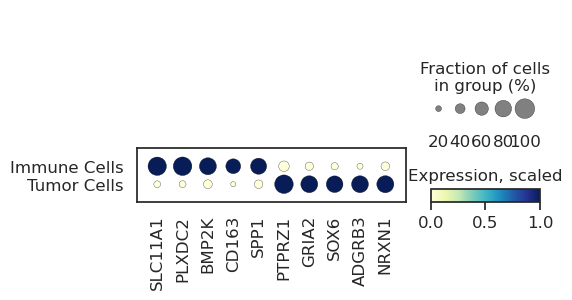

<Figure size 640x480 with 0 Axes>

In [72]:
sns.set_theme(style="white", palette="pastel", font_scale = 1.2, rc={"lines.linewidth": 0.5})
save_path='_rna_marker_genes.pdf'

sc.pl.dotplot(rna_core, var_names=celltype_genes2, 
              groupby='celltype_leiden',colorbar_title='Expression, scaled',
              #categories_order=[ 'Brain neurons', 'mOli', 'Microglia'  ,'Astrocytes', 'Tumor cells' ], 
              standard_scale='var', 
              cmap='YlGnBu',  
              
              dendrogram=False,save=save_path)

# Save the figure
fig = plt.gcf()  # Capture current figure
fig.canvas.draw()  # Ensure canvas is updated
save_path_png = 'figures/BTROHT01-core_dotplot_annotated_plots.jpg'
save_path_pdf = 'figures/BTROHT01-core_dotplot_annotated_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')
fig.savefig(save_path_pdf, bbox_inches='tight')

# Display plot
plt.show()

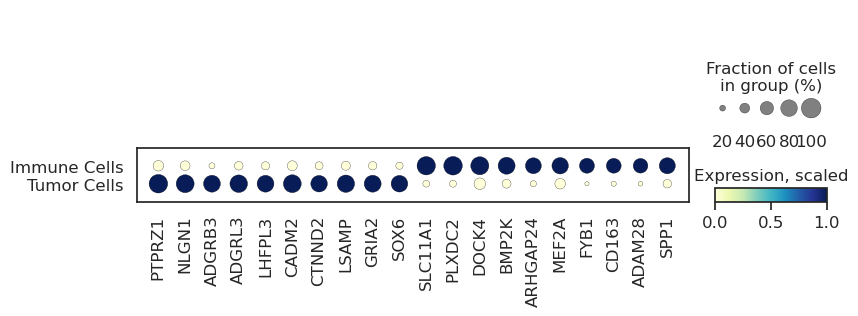

In [73]:
sns.set_theme(style="white", palette="pastel", font_scale = 1.2, rc={"lines.linewidth": 0.5})
save_path='_rna_marker_genes.pdf'

sc.pl.dotplot(rna_core, var_names=gene_names, 
              groupby='celltype_leiden',colorbar_title='Expression, scaled',
              #categories_order=[ 'Brain neurons', 'mOli', 'Microglia'  ,'Astrocytes', 'Tumor cells' ], 
              standard_scale='var', 
              cmap='YlGnBu',  
              
              dendrogram=False,save=save_path)

## Save Final Version 

In [76]:
BASE_DIR

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core'

In [77]:
# Save the file
rna_core.write(f'{BASE_DIR}/BTROHT01_5_core_rna_ANNOTATED_FINAL.h5ad')

## Reading RNA and ATAC data 

In [9]:
import scanpy as sc

import muon as mu

from muon import atac as ac
from muon import prot as pt

import scipy
import numpy as np 
import pandas as pd
 
from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd


In [39]:
rna_core = sc.read(f'{BASE_DIR}/BTROHT01_5_core_rna_ANNOTATED_FINAL.h5ad')

In [40]:
rna_core

AnnData object with n_obs × n_vars = 464 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans_cluster', 'leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'celltypist_conf_score_Adult_Human_PrefrontalCortex', 'cnv_raw_l1', 'cnv_raw_l2', 'cnv_score', 'cnv_leiden', 'celltype', 'celltype_leiden', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex_colors', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex_colors', 'celltype_colors', 'celltype_leiden_colors', 'cnv_leiden_colors', 'dendrogram_celltype', 'hvg', 'leiden', 'leide

In [61]:
atac = sc.read(f'{BASE_DIR}/BTROHT01_3_core_atac_raw.h5ad')

In [62]:
atac

AnnData object with n_obs × n_vars = 518 × 152566
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

## Reading RNA and ATAC DATA

## ATAC seq analysis¶

In [ ]:
#atac = mdata_core.mod['atac']
#atac

## QC for ATAC

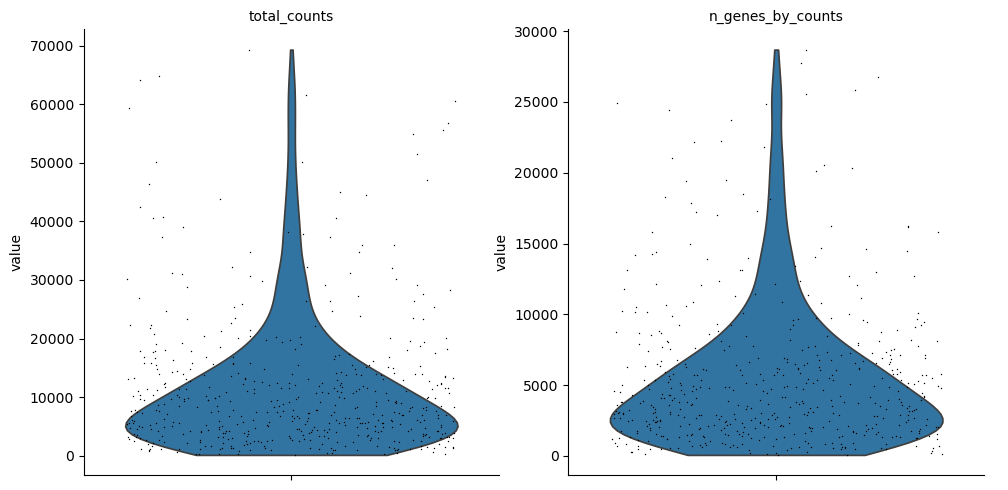

In [23]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

save_path = 'QC_ATAC_before_filtration.pdf'
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True, save=save_path)

## Nucleosome signal 

In [24]:
# Calculate the nucleosome signal across cells
# set n=10e3*atac.n_obs for rough estimate but faster run time
ac.tl.nucleosome_signal(atac, n=10e3 * atac.n_obs)

[W::hts_idx_load3] The index file is older than the data file: /group/sottoriva/00-PROCESSED_DATA/2023-ROVIGO/pre_demultiplexing/BTHROHT01_BTHROHT02_BTHROHT04/multiome/LAZ_315/atac_fragments.tsv.gz.tbi
Reading Fragments: 100%|██████████| 5180000/5180000 [00:11<00:00, 441735.74it/s]


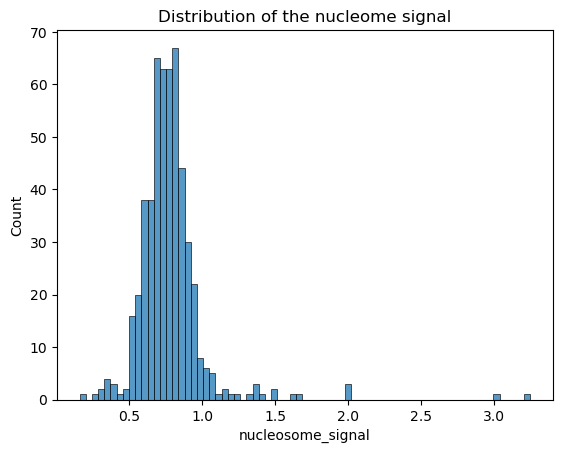

In [25]:
sns.histplot(atac.obs, x="nucleosome_signal")
plt.title("Distribution of the nucleome signal")
plt.show()

## Filtration 

In [26]:
mu.pp.filter_var(atac, "n_cells_by_counts", lambda x: x >= 5)

In [27]:
# mu.pp.filter_obs(
#     atac,
#     "tss_score",
#     lambda x: x >= 2,
# )
print(f"Number of cells after filtering on tss_score: {atac.n_obs}")
mu.pp.filter_obs(atac, "nucleosome_signal", lambda x: x <= 2)
print(f"Number of cells after filtering on nucleosome_signal: {atac.n_obs}")

Number of cells after filtering on tss_score: 518
Number of cells after filtering on nucleosome_signal: 516


In [28]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 50000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

#mu.pp.filter_obs(
#    atac,
#    "total_counts",
#    lambda x: (x >= 500) & (x <= 150000), 
#)
print(f"Number of cells after filtering on n fragments: {atac.n_obs}")

Number of cells after filtering on n fragments: 393


In [29]:
# Define the metrics
atac_metrics = {
    "atac_n_cells_by_counts": 5,
    "atac_n_genes_by_counts_bottom": 2000,
    "atac_n_genes_by_counts_top": 50000,
   # "atac_total_counts_top": 500,
   # "atac_total_counts_bottom": 150000,
}

# Define the file path
file_path = "QC_filtration_metrics.txt"

with open(file_path, 'a') as file:
    for key, value in atac_metrics.items():
        file.write(f"{key}: {value}\n")

print(f"Metrics have been written and appended to {file_path}")

Metrics have been written and appended to QC_filtration_metrics.txt


In [30]:
BASE_DIR

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core'

In [64]:
atac.write(f'{BASE_DIR}/BTROHT01_6_core_atac_QcFiltered.h5ad')

In [65]:
atac

View of AnnData object with n_obs × n_vars = 446 × 152566
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

## SnapATAC and filtration¶

In [26]:
atac = sc.read(f'{BASE_DIR}/BTROHT01_6_core_atac_QcFiltered.h5ad')

In [27]:
import snapatac2 as snap
import numpy as np
import scanpy as sc

snap.__version__

'2.8.0'

In [28]:
#Choose barcodes from filtered data (filtered with muon)
valid_barcodes=atac.obs_names
len(valid_barcodes)

446

In [29]:
BASE_DIR

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core'

In [30]:
%%time

data = snap.pp.import_data(
    f'{BASE_DIR}/Snap/atac_fragments.tsv',
    chrom_sizes=snap.genome.hg38,
    file="/scratch/fatemeh.nasrabadi/importsnt/STORAGE/snap_files/BTROHT1_core_snap.h5ad",  # Optional
    sorted_by_barcode=False, whitelist=valid_barcodes,
    tempdir=f'{BASE_DIR}/Snap/tmpdir'
)
data

CPU times: user 9min 48s, sys: 21.3 s, total: 10min 9s
Wall time: 6min 44s


<timed exec>:1: DeprecationWarning: import_data is deprecated and will be removed in v2.9.0. Use import_fragments instead.


AnnData object with n_obs x n_vars = 446 x 0 backed at '/scratch/fatemeh.nasrabadi/importsnt/STORAGE/snap_files/BTROHT1_core_snap.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [31]:
data.close()

## Read Snap ATAC

In [25]:
data=snap.read(f'{BASE_DIR}/Snap/BTROHT_core_snap.h5ad', )
data

AnnData object with n_obs x n_vars = 464 x 0 backed at '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core/Snap/BTROHT_core_snap.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

## QC 

2024-11-27 21:05:13 - INFO - Computing fragment size distribution...


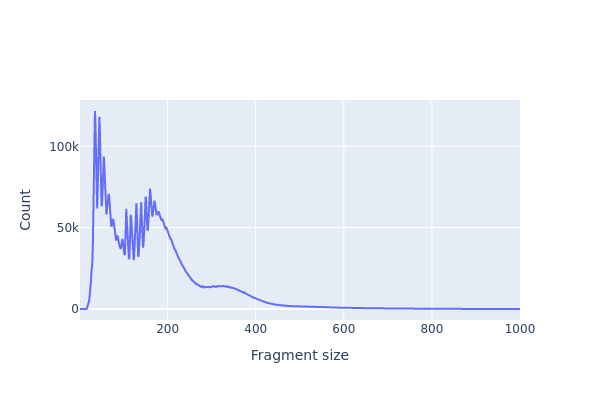

In [26]:
snap.pl.frag_size_distr(data, interactive=False, out_file='figures/QC_ATAC_frag_size_distr.pdf')

In [27]:
%%time
snap.metrics.tsse(data, snap.genome.hg38)

CPU times: user 10.3 s, sys: 563 ms, total: 10.9 s
Wall time: 12.8 s


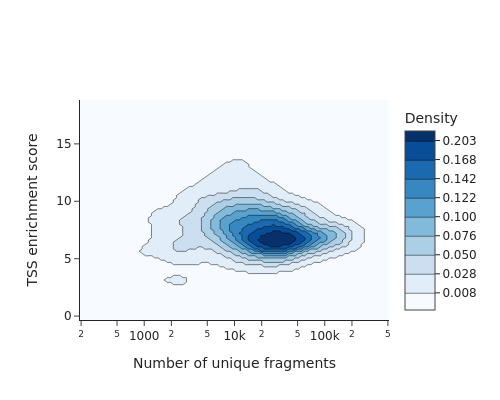

In [28]:
snap.pl.tsse(data, interactive=False, out_file='figures/QC_ATAC_tsse_frags.pdf')

In [29]:
data.obs['tsse'].min()

/tmp/ipykernel_2260745/1383754455.py:1: DeprecationWarning:

`Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'



1.5810276679841897

In [30]:
data.obs['tsse'].mean()

/tmp/ipykernel_2260745/921509436.py:1: DeprecationWarning:

`Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'



7.459747006511083

In [31]:
## Add tile matrix, select features, remove doublets, 

In [32]:
%%time
snap.pp.add_tile_matrix(data) #add tile matrix with 500 bp window

CPU times: user 10.2 s, sys: 874 ms, total: 11.1 s
Wall time: 12.1 s


In [33]:
snap.pp.select_features(data, n_features=25000) #feature selection to find the most variable

2024-11-27 21:06:50 - INFO - Selected 25000 features.


In [34]:
%%time
snap.pp.scrublet(data) #doublet identification

2024-11-27 21:06:52 - INFO - Simulating doublets...
2024-11-27 21:06:52 - INFO - Spectral embedding ...
2024-11-27 21:06:54 - INFO - Calculating doublet scores...


CPU times: user 4.21 s, sys: 275 ms, total: 4.48 s
Wall time: 12.9 s


In [35]:
snap.pp.filter_doublets(data) #doublet removal
data

2024-11-27 21:07:04 - INFO - Detected doublet rate = 3.879%


AnnData object with n_obs x n_vars = 446 x 6062095 backed at '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core/Snap/BTROHT_core_snap.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'doublet_rate', 'frac_overlap_TSS', 'library_tsse', 'reference_sequences', 'TSS_profile', 'frag_size_distr', 'scrublet_sim_doublet_score'
    obsm: 'fragment_paired'

In [36]:
data.write(f'{BASE_DIR}/Snap/BTROHT_core_snap_filtered.h5ad', )

In [38]:
data.close()

In [39]:
data = snap.read(f'{BASE_DIR}/Snap/BTROHT_core_snap_filtered.h5ad', )

In [40]:
data

AnnData object with n_obs x n_vars = 446 x 6062095 backed at '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core/Snap/BTROHT_core_snap_filtered.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'TSS_profile', 'frac_overlap_TSS', 'frag_size_distr', 'reference_sequences', 'doublet_rate', 'library_tsse', 'scrublet_sim_doublet_score'
    obsm: 'fragment_paired'

## Reducing Dimentions

In [19]:
data = snap.read(f'{BASE_DIR}/Snap/BTROHT_core_snap_filtered.h5ad', )

In [20]:
data

AnnData object with n_obs x n_vars = 446 x 6062095 backed at '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core/Snap/BTROHT_core_snap_filtered.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'scrublet_sim_doublet_score', 'doublet_rate', 'frag_size_distr', 'spectral_eigenvalue', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'X_umap', 'X_spectral', 'fragment_paired'
    obsp: 'distances'

In [41]:
%%time
snap.tl.spectral(data, n_comps=40)

CPU times: user 1.47 s, sys: 185 ms, total: 1.65 s
Wall time: 2 s


In [42]:
%%time
snap.tl.umap(data, )

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



CPU times: user 5.64 s, sys: 63.9 ms, total: 5.71 s
Wall time: 5.69 s


In [35]:
%%time
snap.pp.knn(data)
snap.tl.leiden(data,resolution= 3)

CPU times: user 35.4 ms, sys: 2.67 ms, total: 38.1 ms
Wall time: 38.2 ms


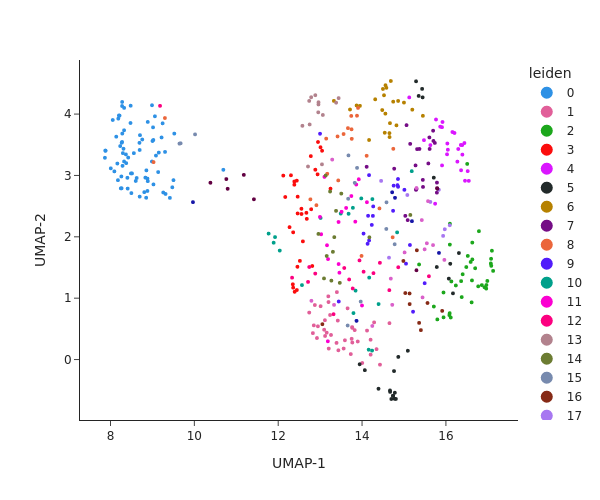

In [30]:
snap.pl.umap(data, color='leiden', interactive=False, height=500)

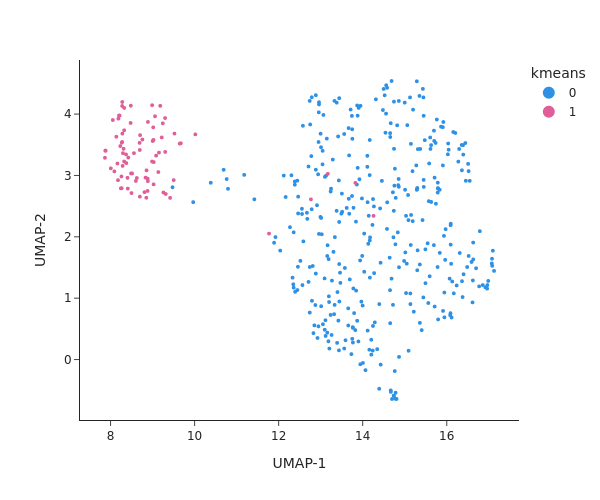

In [42]:
snap.tl.kmeans(data,n_clusters = 2 )
snap.pl.umap(data, color="kmeans", interactive=False, height=500)

In [1]:
data

NameError: name 'data' is not defined

In [46]:
data

Closed AnnData object

## Cluster Annotation

In [17]:
import snapatac2 as snap
import numpy as np
import scanpy as sc

snap.__version__

'2.7.0'

In [18]:
data = snap.read(f'{BASE_DIR}/Snap/BTROHT_core_snap_filtered.h5ad', )
data

AnnData object with n_obs x n_vars = 446 x 6062095 backed at '/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core/Snap/BTROHT_core_snap_filtered.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'frac_overlap_TSS', 'TSS_profile', 'library_tsse', 'reference_sequences', 'doublet_rate', 'spectral_eigenvalue', 'scrublet_sim_doublet_score', 'frag_size_distr'
    obsm: 'X_umap', 'fragment_paired', 'X_spectral'
    obsp: 'distances'

In [46]:
%%time
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.hg38, )
gene_matrix

CPU times: user 27.4 s, sys: 464 ms, total: 27.9 s
Wall time: 16.8 s


/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 446 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'

In [86]:
rna_core

AnnData object with n_obs × n_vars = 464 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans_cluster', 'leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'celltypist_conf_score_Adult_Human_PrefrontalCortex', 'cnv_raw_l1', 'cnv_raw_l2', 'cnv_score', 'cnv_leiden', 'celltype', 'celltype_leiden', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex_colors', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex_colors', 'celltype_colors', 'celltype_leiden_colors', 'cnv_leiden_colors', 'dendrogram_celltype', 'hvg', 'leiden', 'leide

In [47]:
# Initialize all values in gene_matrix.obs['annotation'] as None
gene_matrix.obs['celltype'] = None

# Update the annotation for cells that are present in both gene_matrix.obs and data.obs
common_cells = gene_matrix.obs.index.intersection(rna_core.obs.index)
gene_matrix.obs.loc[common_cells, 'celltype'] = rna_core.obs.loc[common_cells, 'celltype']


In [48]:
# Copy over UMAP embedding
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]

In [49]:
# Count occurrences of each type in the 'annotation' column
annotation_counts = gene_matrix.obs['celltype'].value_counts()

# Display the counts
print(annotation_counts)


celltype
Tumor Cells     364
Immune Cells     82
Name: count, dtype: int64


... storing 'celltype' as categorical


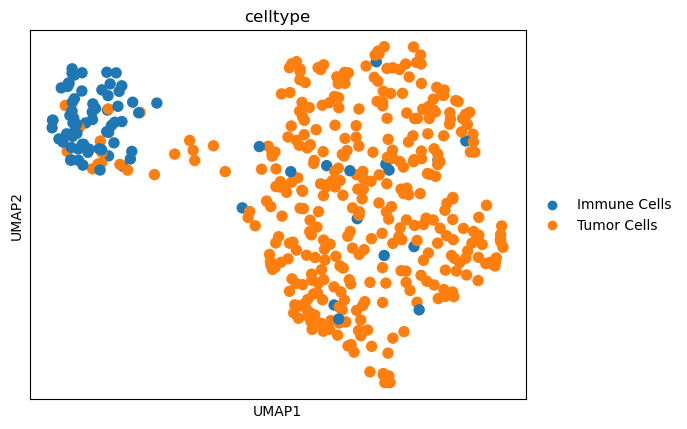

In [50]:
markers = ['celltype']
sc.pl.umap(gene_matrix, use_raw=False, color= markers , ncols=2)

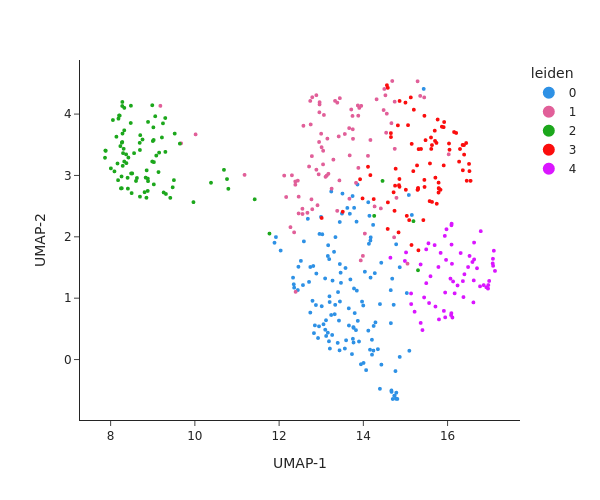

In [51]:
snap.pl.umap(data, color='leiden', interactive=False, height=500)

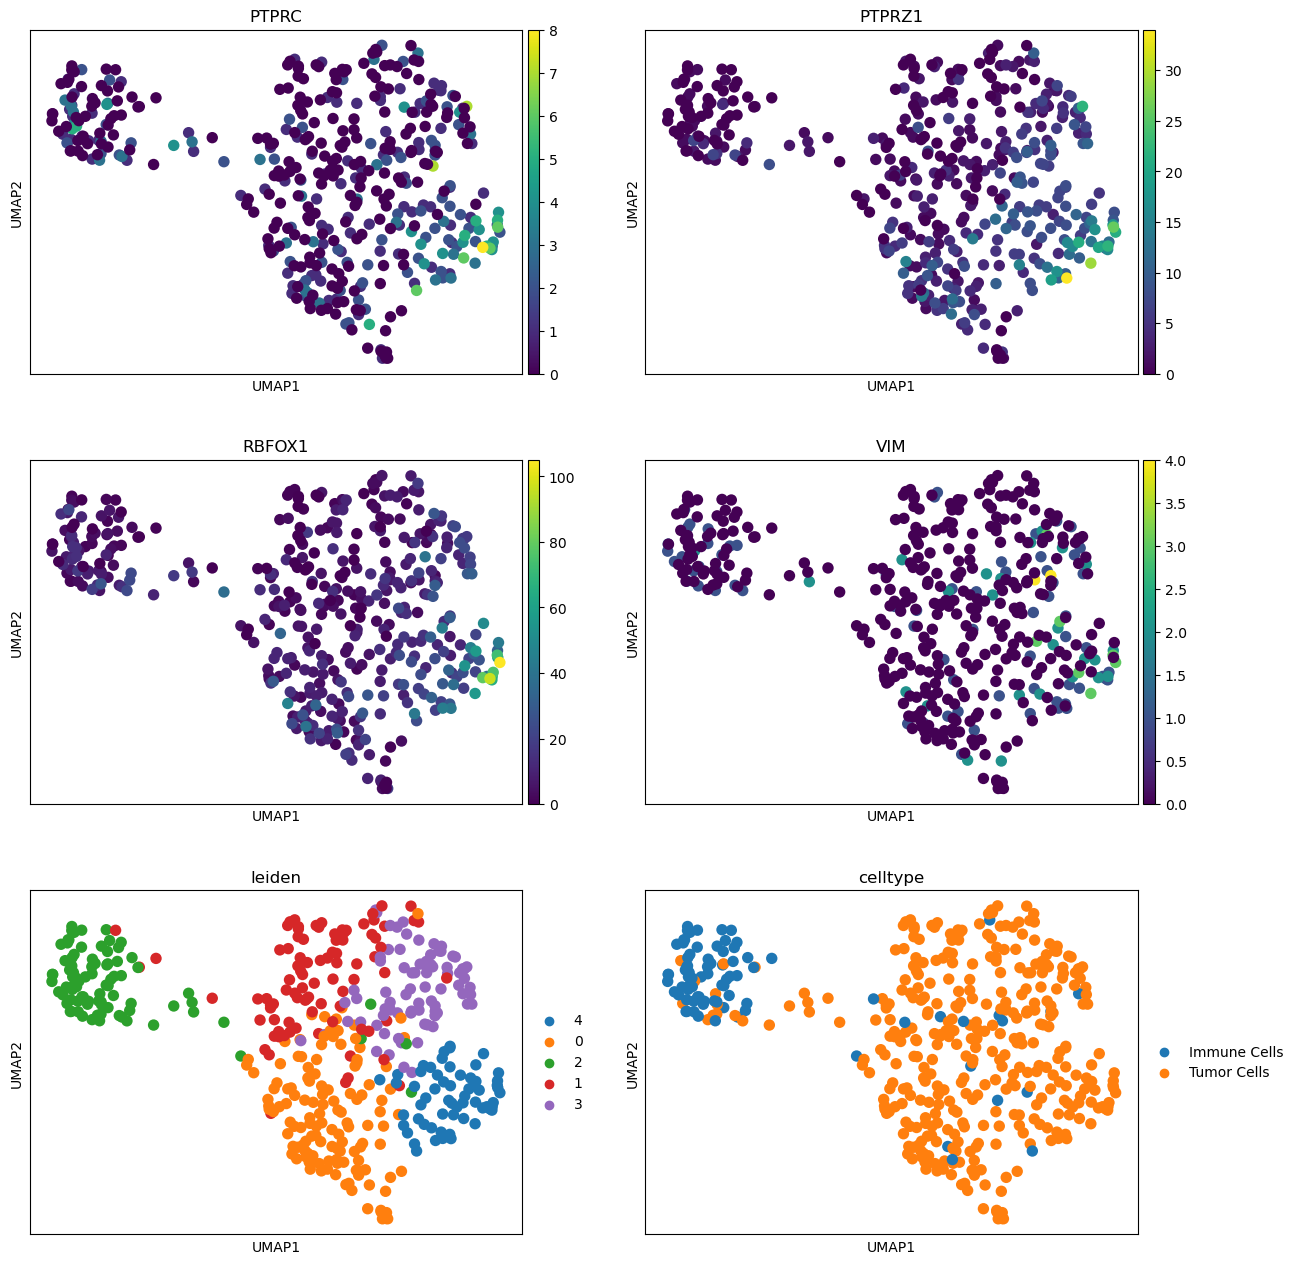

In [52]:
markers = ['PTPRC', 'PTPRZ1', 'RBFOX1','VIM', 'leiden','celltype']
sc.pl.umap(gene_matrix, use_raw=False, color= markers , ncols=2)

In [53]:
gene_matrix.obs['UMAP of ATAC in BTROH01-Core'] = gene_matrix.obs['celltype'] 

<Figure size 200x300 with 0 Axes>

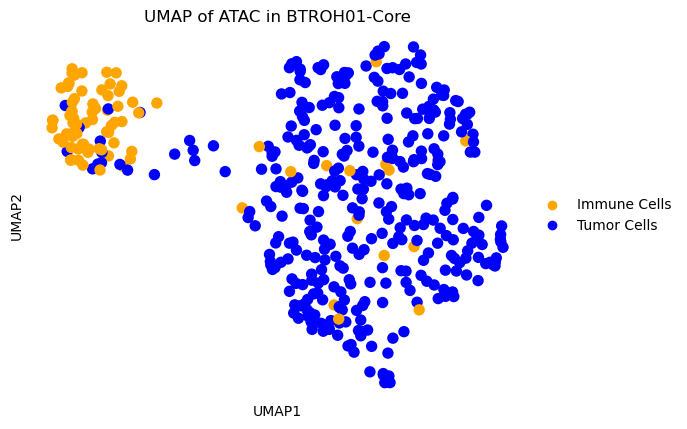

In [54]:
import os
import matplotlib.pyplot as plt
import scanpy as sc

# Assuming 'gene_matrix' is your AnnData object

# Define the markers and their corresponding colors
markers = ['UMAP of ATAC in BTROH01-Core']
color_map = {
    'Immune Cells': 'orange',
    'Tumor Cells': 'blue',
}

# Ensure the output directory exists
output_dir = 'figures'
os.makedirs(output_dir, exist_ok=True)

# Set figure size using matplotlib before plotting
plt.figure(figsize=(2, 3))

# Create a UMAP plot with specified colors
sc.pl.umap(
    gene_matrix,
    use_raw=False,
    color=markers,
    ncols=2,
    palette=color_map,
    show=False
)

# Remove the box around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Save the figure
fig = plt.gcf()  # Capture current figure
save_path_png = os.path.join(output_dir, 'core_atac_annotated_plots.jpg')
save_path_pdf = os.path.join(output_dir, 'core_atac_annotated_plots.pdf')
fig.savefig(save_path_png, bbox_inches='tight')
fig.savefig(save_path_pdf, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
"""
import scanpy as sc

# Assuming 'gene_matrix' is your AnnData object

# Define the markers you want to plot
markers = ['leiden', 'UMAP of ATAC in BTROH01-Core']

# Assign 'NA' cells based on 'leiden' clustering
na_cells = gene_matrix.obs['annotation'].isna()
gene_matrix.obs.loc[na_cells & (gene_matrix.obs['leiden'] == '2'), 'UMAP of ATAC in BTROH01-Core'] = "Immune Cells"
gene_matrix.obs.loc[na_cells & (gene_matrix.obs['leiden'] != '2'), 'UMAP of ATAC in BTROH01-Core'] = "Tumor Cells"

# Define the color palette for the markers
custom_palette = [ 'orange','blue']  # Blue for 'leiden' and Orange for 'annotation'

# Create the UMAP plot without box around the plots
sc.pl.umap(gene_matrix, use_raw=False, color=markers, ncols=2, palette=custom_palette, frameon=False)



# Save the figure
fig = plt.gcf()  # Capture current figure
fig.canvas.draw()  # Ensure canvas is updated
save_path_png = 'figures/core_atac_annotated_plots.jpg'
save_path_pdf = 'figures/core_atac_annotated_plots.pdf'
fig.savefig(save_path_png, bbox_inches='tight')
fig.savefig(save_path_pdf, bbox_inches='tight')

# Display plot
plt.show() 

""""

In [55]:
gene_matrix

AnnData object with n_obs × n_vars = 446 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH01-Core'
    uns: 'celltype_colors', 'leiden_colors', 'UMAP of ATAC in BTROH01-Core_colors'
    obsm: 'X_umap'

In [56]:
gene_matrix.write(f'{BASE_DIR}/BTROHT01_7_core_gene_matrix_ANNOTATED_FINAL.h5ad')

In [57]:
gene_matrix=sc.read(f'{BASE_DIR}/BTROHT01_7_core_gene_matrix_ANNOTATED_FINAL.h5ad')

In [58]:
gene_matrix

AnnData object with n_obs × n_vars = 446 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH01-Core'
    uns: 'UMAP of ATAC in BTROH01-Core_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

In [59]:
rna_core

AnnData object with n_obs × n_vars = 464 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans_cluster', 'leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'celltypist_conf_score_Adult_Human_PrefrontalCortex', 'cnv_raw_l1', 'cnv_raw_l2', 'cnv_score', 'cnv_leiden', 'celltype', 'celltype_leiden', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex_colors', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex_colors', 'celltype_colors', 'celltype_leiden_colors', 'cnv_leiden_colors', 'dendrogram_celltype', 'hvg', 'leiden', 'leide

In [34]:
atac = sc.read(f'{BASE_DIR}/BTROHT01_6_core_atac_QcFiltered.h5ad')

In [38]:
atac

AnnData object with n_obs × n_vars = 393 × 140141
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

In [36]:
rna_core

AnnData object with n_obs × n_vars = 464 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans_cluster', 'leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'celltypist_conf_score_Adult_Human_PrefrontalCortex', 'cnv_raw_l1', 'cnv_raw_l2', 'cnv_score', 'cnv_leiden', 'celltype', 'celltype_leiden', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex_colors', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex_colors', 'celltype_colors', 'celltype_leiden_colors', 'cnv_leiden_colors', 'dendrogram_celltype', 'hvg', 'leiden', 'leide

In [37]:
gene_matrix

AnnData object with n_obs × n_vars = 446 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH01-Core'
    uns: 'UMAP of ATAC in BTROH01-Core_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

## Normalization 

In [ ]:
#gff and gtf gene anno

In [66]:
atac= atac[list(set(gene_matrix.obs_names) & set(rna_core.obs_names)), :]
atac

View of AnnData object with n_obs × n_vars = 446 × 152566
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

In [67]:
atac.layers["counts"] = atac.X

/tmp/ipykernel_2291637/1225148405.py:1: ImplicitModificationWarning:

Setting element `.layers['counts']` of view, initializing view as actual.



In [68]:
ac.pp.tfidf(atac, scale_factor=1e4)

/home/fatemeh.nasrabadi/anaconda3/envs/anaconda_singlecell_env/lib/python3.9/site-packages/muon/_atac/preproc.py:106: RuntimeWarning:

divide by zero encountered in divide



In [69]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)

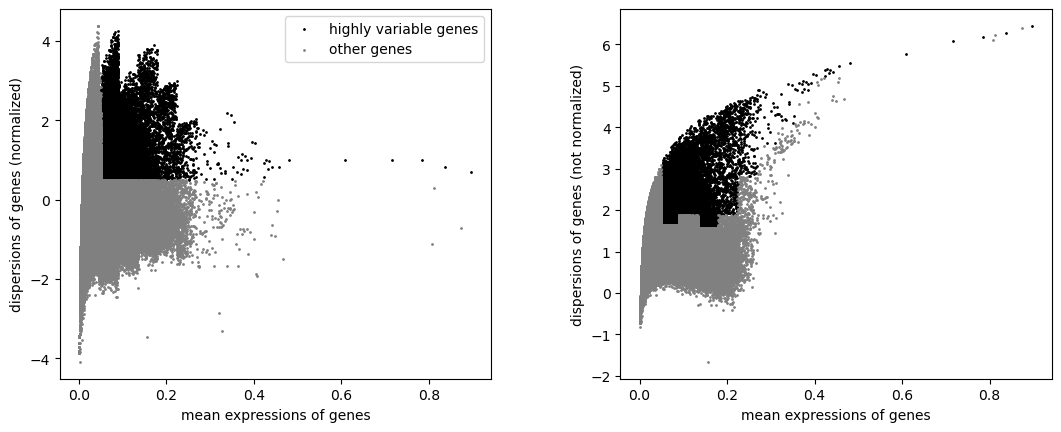

In [70]:
sc.pp.log1p(atac)
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)
sc.pl.highly_variable_genes(atac)
np.sum(atac.var.highly_variable)
atac.raw = atac

## LSI, gragh on LSI, PCA

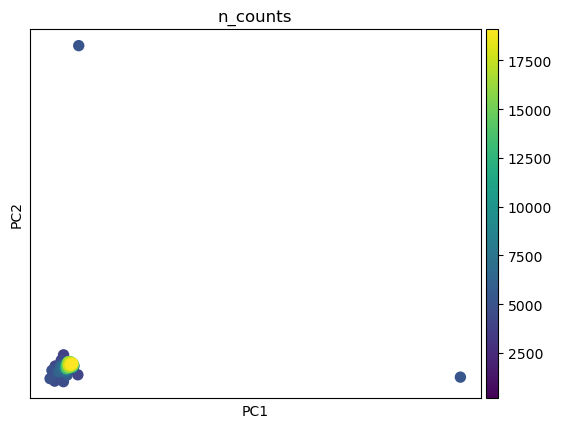

In [71]:
ac.tl.lsi(atac)
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:] #We find the first component is typically associated with number of peaks or counts per cell so it is reasonable to remove it
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.pp.scale(atac)
sc.tl.pca(atac)
sc.pl.pca(atac, color= ["n_counts"])


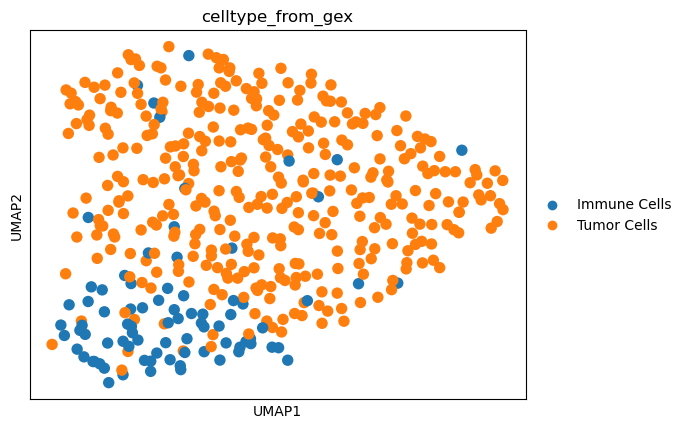

In [73]:
sc.tl.umap(atac)
atac.obs['celltype_from_gex']=rna_core.obs['celltype'].reindex(atac.obs_names)
sc.pl.umap(atac, color=["celltype_from_gex"])

## Graph on PCA 

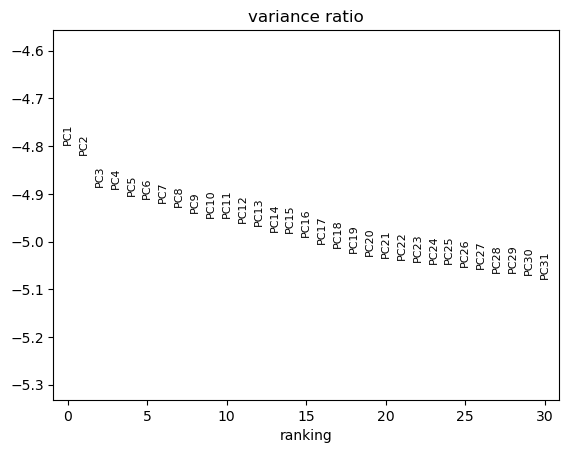

/tmp/ipykernel_2291637/1366298863.py:3: FutureWarning:

In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.



In [74]:
sc.pl.pca_variance_ratio(atac, log=True, )
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=20)
sc.tl.leiden(atac, resolution=.6)
sc.tl.umap(atac, spread=1, min_dist=.1, random_state=20)
#atac.obs['celltype_from_atac']=gene_matrix.obs['celltype_final'].reindex(atac.obs_names)
#atac.obs['celltype_from_gex']=rna.obs['celltype_with_tumor'].reindex(atac.obs_names)


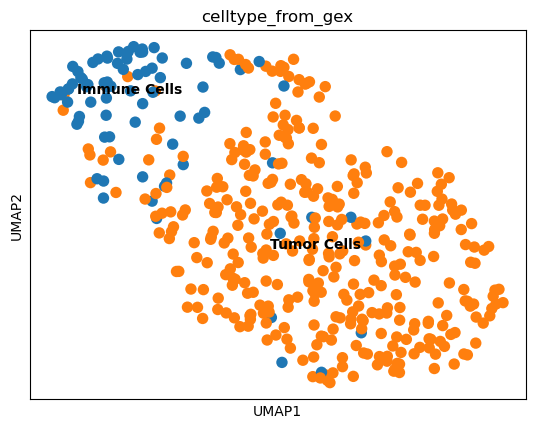

In [76]:
sc.pl.umap(atac, color=["celltype_from_gex"], legend_loc="on data")

In [77]:
atac.write(f'{BASE_DIR}/BTROHT01_8_core_atac_ANNOTATED_FINAL.h5ad')

# 4 0 1 3 

## for CONGAS 

## Barcode

In [9]:
gene_matrix=sc.read(f'{BASE_DIR}/BTROHT01_7_core_gene_matrix_ANNOTATED_FINAL.h5ad')

In [10]:
gene_matrix

AnnData object with n_obs × n_vars = 446 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH01-Core'
    uns: 'UMAP of ATAC in BTROH01-Core_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

In [11]:
gene_matrix.obs['celltype'].value_counts()

celltype
Tumor Cells     364
Immune Cells     82
Name: count, dtype: int64

In [12]:
write_dataset(pd.DataFrame(gene_matrix.obs['celltype']),
               f'{BASE_DIR}/CONGAS/BTROHT01_core_barcodes_all.tsv')

In [13]:
write_dataset(pd.DataFrame(gene_matrix.obs[gene_matrix.obs['celltype'].isin(['Tumor Cells'])]['celltype']),
               f'{BASE_DIR}/CONGAS/BTROHT01_core_barcodes_tumorcells_.tsv')

In [14]:
import pandas as pd


# Read the TSV file into a DataFrame
df = pd.read_csv(f'{BASE_DIR}/CONGAS/BTROHT01_core_barcodes_tumorcells_.tsv', sep='\t')

# Display the first few rows of the table
print(df.head())

# If you want to see the entire table
print(df)


           Unnamed: 0     celltype
0  AAACGGATCATTGCAA-1  Tumor Cells
1  AAACGGATCTCAATTC-1  Tumor Cells
2  AAAGCGGGTCATGCAA-1  Tumor Cells
3  AAAGCTTGTCACTCGC-1  Tumor Cells
4  AAAGCTTGTTAGGATT-1  Tumor Cells
             Unnamed: 0     celltype
0    AAACGGATCATTGCAA-1  Tumor Cells
1    AAACGGATCTCAATTC-1  Tumor Cells
2    AAAGCGGGTCATGCAA-1  Tumor Cells
3    AAAGCTTGTCACTCGC-1  Tumor Cells
4    AAAGCTTGTTAGGATT-1  Tumor Cells
..                  ...          ...
359  TTTGACCGTCCTTTAA-1  Tumor Cells
360  TTTGCGGAGCCAGTAT-1  Tumor Cells
361  TTTGGTGCACACAATT-1  Tumor Cells
362  TTTGTGGCAAGTCGCT-1  Tumor Cells
363  TTTGTTGGTGCTAGAC-1  Tumor Cells

[364 rows x 2 columns]


## Segment file

In [15]:
segs = pd.read_csv(f'{BASE_DIR}/CONGAS/BTROHT01_T3.seg.txt' , sep = '\t' )
segs 

ID chrom     start        end  num.mark  seg.median.logR  \
0   BTROHT01_T3     1   1000001  248000000       247         0.024344   
1   BTROHT01_T3     2   1000001  242000000       241         0.021441   
2   BTROHT01_T3     3   1000001  198000000       197         0.011203   
3   BTROHT01_T3     4   2000001  189000000       187        -0.018155   
4   BTROHT01_T3     5   1000001  181000000       180        -0.006821   
5   BTROHT01_T3     6   1000001  170000000       169        -0.012902   
6   BTROHT01_T3     7   1000001  159000000       158         0.431320   
7   BTROHT01_T3     8   1000001  145000000       144         0.004162   
8   BTROHT01_T3     9   1000001  138000000       137        -0.003340   
9   BTROHT01_T3    10   1000001  133000000       132        -0.656806   
10  BTROHT01_T3    11   1000001  135000000       134         0.002129   
11  BTROHT01_T3    12   1000001  132000000       131        -0.012383   
12  BTROHT01_T3    13  20000001  113000000        93        -0.162139   
13  BTROHT01_T3    14  20000001  105000000        85        -0.656477   
14  BTROHT01_T3    15  25000001  101000000        76        -0.000860   
15  BTROHT01_T3    16   1000001   90000000        89        -0.003175   
16  BTROHT01_T3    17   1000001   83000000        82        -0.012466   
17  BTROHT01_T3    18   1000001   80000000        79        -0.017217   
18  BTROHT01_T3    19   1000001   58000000        57        -0.027225   
19  BTROHT01_T3    20   1000001   64000000        63         0.006349   
20  BTROHT01_T3    21  14000001   46000000        32        -0.029643   
21  BTROHT01_T3    22  19000001   49000000        30        -0.503120   
22  BTROHT01_T3     X   4000001  154000000       150        -0.022623   

    copy.number  call  subclone.status  logR_Copy_Number  \
0             2  NEUT            False          2.051394   
1             2  NEUT            False          2.045714   
2             2  NEUT            False          2.025768   
3             2  NEUT            False          1.969356   
4             2  NEUT            False          1.990998   
5             2  NEUT            False          1.979365   
6             3  GAIN            False          2.972451   
7             2  NEUT            False          2.012135   
8             2  NEUT            False          1.997680   
9             1  HETD            False          0.987819   
10            2  NEUT            False          2.008211   
11            2  NEUT            False          1.980357   
12            2  NEUT            False          1.708709   
13            1  HETD            False          0.988221   
14            2  NEUT            False          2.002450   
15            2  NEUT            False          1.997996   
16            2  NEUT            False          1.980197   
17            2  NEUT            False          1.971140   
18            2  NEUT            False          1.952157   
19            2  NEUT            False          2.016363   
20            2  NEUT            False          1.947591   
21            1  HETD            False          1.185948   
22            2  NEUT            False          1.960870   

    Corrected_Copy_Number Corrected_Call  
0                       2           NEUT  
1                       2           NEUT  
2                       2           NEUT  
3                       2           NEUT  
4                       2           NEUT  
5                       2           NEUT  
6                       3           GAIN  
7                       2           NEUT  
8                       2           NEUT  
9                       1           HETD  
10                      2           NEUT  
11                      2           NEUT  
12                      2           NEUT  
13                      1           HETD  
14                      2           NEUT  
15                      2           NEUT  
16                      2           NEUT  
17                      2           NEUT  
18

In [16]:
segs=segs[['chrom', 'start', 'end', 'copy.number']]

In [17]:
segs=segs.rename(columns={'chrom':'chr',
                          'start':'from', 
                          'end':'to', 
                          'copy.number':'copies'})
segs

chr      from         to  copies
0    1   1000001  248000000       2
1    2   1000001  242000000       2
2    3   1000001  198000000       2
3    4   2000001  189000000       2
4    5   1000001  181000000       2
5    6   1000001  170000000       2
6    7   1000001  159000000       3
7    8   1000001  145000000       2
8    9   1000001  138000000       2
9   10   1000001  133000000       1
10  11   1000001  135000000       2
11  12   1000001  132000000       2
12  13  20000001  113000000       2
13  14  20000001  105000000       1
14  15  25000001  101000000       2
15  16   1000001   90000000       2
16  17   1000001   83000000       2
17  18   1000001   80000000       2
18  19   1000001   58000000       2
19  20   1000001   64000000       2
20  21  14000001   46000000       2
21  22  19000001   49000000       1
22   X   4000001  154000000       2

In [18]:
segs['chr'] = 'chr' + segs['chr'].astype(str)
segs

chr      from         to  copies
0    chr1   1000001  248000000       2
1    chr2   1000001  242000000       2
2    chr3   1000001  198000000       2
3    chr4   2000001  189000000       2
4    chr5   1000001  181000000       2
5    chr6   1000001  170000000       2
6    chr7   1000001  159000000       3
7    chr8   1000001  145000000       2
8    chr9   1000001  138000000       2
9   chr10   1000001  133000000       1
10  chr11   1000001  135000000       2
11  chr12   1000001  132000000       2
12  chr13  20000001  113000000       2
13  chr14  20000001  105000000       1
14  chr15  25000001  101000000       2
15  chr16   1000001   90000000       2
16  chr17   1000001   83000000       2
17  chr18   1000001   80000000       2
18  chr19   1000001   58000000       2
19  chr20   1000001   64000000       2
20  chr21  14000001   46000000       2
21  chr22  19000001   49000000       1
22   chrX   4000001  154000000       2

In [21]:
write_dataset(segs,
               f'{BASE_DIR}/CONGAS/BTROHT01_copre_segs_for_congas.csv')

In [20]:
segs.loc[[6, 9, 13]]

chr      from         to  copies
6    chr7   1000001  159000000       3
9   chr10   1000001  133000000       1
13  chr14  20000001  105000000       1

In [22]:
write_dataset(segs.loc[[6, 9, 13]], f'{BASE_DIR}/CONGAS/BTROHT01_copre_segs_for_congas_chr7_chr10_chr14.csv')

In [24]:
BASE_DIR
/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core/BTROHT01_copre_segs_for_congas.csv

'/home/fatemeh.nasrabadi/ROVIGO_congas/BTROHT01/Core'

In [23]:
#END

# Cluster from CONGAS 

In [13]:
gene_matrix=sc.read(f'{BASE_DIR}/BTROHT01_7_core_gene_matrix_ANNOTATED_FINAL.h5ad')

In [14]:
gene_matrix

AnnData object with n_obs × n_vars = 446 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH01-Core'
    uns: 'UMAP of ATAC in BTROH01-Core_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

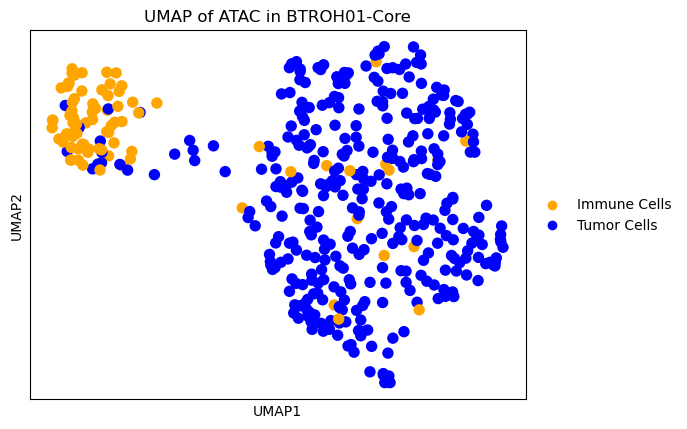

In [15]:
sc.pl.umap(gene_matrix, color='UMAP of ATAC in BTROH01-Core')

In [16]:
clusters_from_congas=pd.read_csv(f'{BASE_DIR}/CONGAS/BTROHT01_core_CONGAS_Clusters.csv', sep=',')
clusters_from_congas

cell cluster modality    multiome_barcode
0    AAACGGATCATTGCAA-1-ATAC      C3     ATAC  AAACGGATCATTGCAA-1
1    AAACGGATCTCAATTC-1-ATAC      C3     ATAC  AAACGGATCTCAATTC-1
2    AAAGCGGGTCATGCAA-1-ATAC      C2     ATAC  AAAGCGGGTCATGCAA-1
3    AAAGCTTGTCACTCGC-1-ATAC      C3     ATAC  AAAGCTTGTCACTCGC-1
4    AAAGCTTGTTAGGATT-1-ATAC      C3     ATAC  AAAGCTTGTTAGGATT-1
..                       ...     ...      ...                 ...
887   TTTGCGGAGCCAGTAT-1-RNA      C3      RNA  TTTGCGGAGCCAGTAT-1
888   TTTGGTGCACACAATT-1-RNA      C3      RNA  TTTGGTGCACACAATT-1
889   TTTGTCTAGGACGTAA-1-RNA      C3      RNA  TTTGTCTAGGACGTAA-1
890   TTTGTGGCAAGTCGCT-1-RNA      C3      RNA  TTTGTGGCAAGTCGCT-1
891   TTTGTTGGTGCTAGAC-1-RNA      C1      RNA  TTTGTTGGTGCTAGAC-1

[892 rows x 4 columns]

In [17]:
clusters_from_congas=clusters_from_congas[clusters_from_congas['modality']=='ATAC']
clusters_from_congas=clusters_from_congas.set_index('multiome_barcode')
clusters_from_congas

cell cluster modality
multiome_barcode                                            
AAACGGATCATTGCAA-1  AAACGGATCATTGCAA-1-ATAC      C3     ATAC
AAACGGATCTCAATTC-1  AAACGGATCTCAATTC-1-ATAC      C3     ATAC
AAAGCGGGTCATGCAA-1  AAAGCGGGTCATGCAA-1-ATAC      C2     ATAC
AAAGCTTGTCACTCGC-1  AAAGCTTGTCACTCGC-1-ATAC      C3     ATAC
AAAGCTTGTTAGGATT-1  AAAGCTTGTTAGGATT-1-ATAC      C3     ATAC
...                                     ...     ...      ...
TTTGCGGAGCCAGTAT-1  TTTGCGGAGCCAGTAT-1-ATAC      C3     ATAC
TTTGGTGCACACAATT-1  TTTGGTGCACACAATT-1-ATAC      C3     ATAC
TTTGTCTAGGACGTAA-1  TTTGTCTAGGACGTAA-1-ATAC      C3     ATAC
TTTGTGGCAAGTCGCT-1  TTTGTGGCAAGTCGCT-1-ATAC      C3     ATAC
TTTGTTGGTGCTAGAC-1  TTTGTTGGTGCTAGAC-1-ATAC      C1     ATAC

[446 rows x 3 columns]

In [18]:
gene_matrix.obs['congas_cluster']=clusters_from_congas.reindex(gene_matrix.obs_names)['cluster']

In [19]:
gene_matrix

AnnData object with n_obs × n_vars = 446 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'celltype', 'UMAP of ATAC in BTROH01-Core', 'congas_cluster'
    uns: 'UMAP of ATAC in BTROH01-Core_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

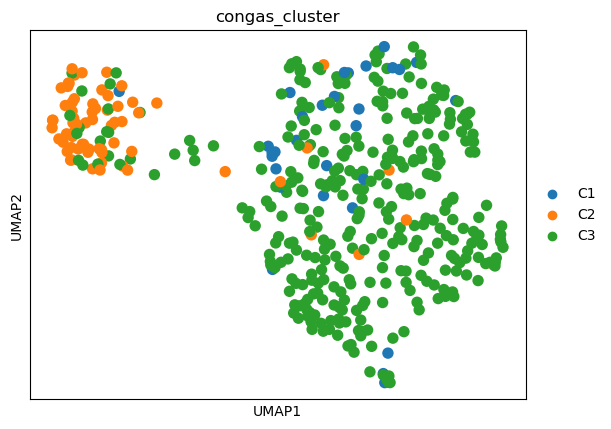

In [20]:
save_path='_ATAC_clusters_congas_all.pdf'
sc.pl.umap(gene_matrix, color=["congas_cluster"] , ncols=2, save=save_path)

# Reannotation - Final annotation 

In [8]:
gene_matrix=sc.read(f'{BASE_DIR}/BTROHT01_7_core_gene_matrix_ANNOTATED_FINAL.h5ad')

In [9]:
rna_core = sc.read(f'{BASE_DIR}/BTROHT01_5_core_rna_ANNOTATED_FINAL.h5ad')

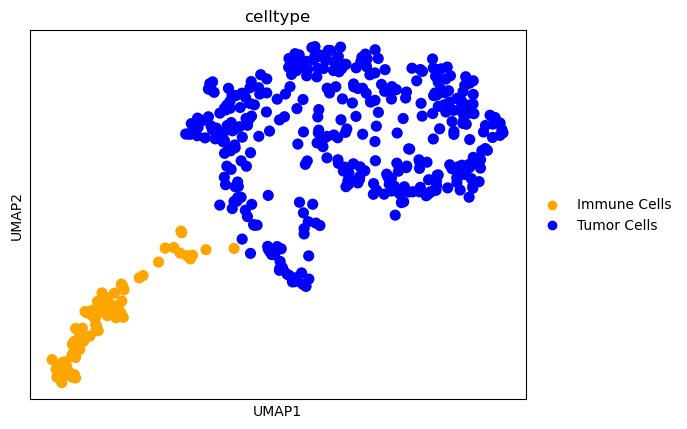

In [10]:
sc.pl.umap(rna_core, color=[ 'celltype'], vmax=20000)

In [12]:
rna_core.obs['celltype'].value_counts()

celltype
Tumor Cells     379
Immune Cells     85
Name: count, dtype: int64

In [14]:
rna_core

AnnData object with n_obs × n_vars = 464 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans_cluster', 'leiden', 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'celltypist_conf_score_Adult_Human_PrefrontalCortex', 'cnv_raw_l1', 'cnv_raw_l2', 'cnv_score', 'cnv_leiden', 'celltype', 'celltype_leiden', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_typist_majority_voting_Adult_Human_PrefrontalCortex_colors', 'cell_typist_predicted_labels_Adult_Human_PrefrontalCortex_colors', 'celltype_colors', 'celltype_leiden_colors', 'cnv_leiden_colors', 'dendrogram_celltype', 'hvg', 'leiden', 'leide

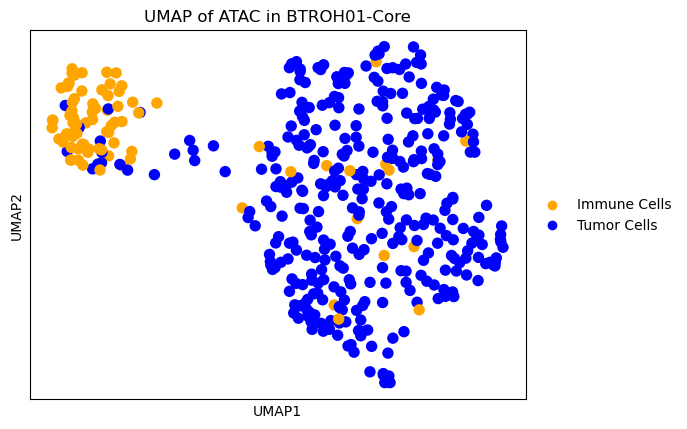

In [11]:
sc.pl.umap(gene_matrix, color='UMAP of ATAC in BTROH01-Core')

In [13]:
gene_matrix.obs['UMAP of ATAC in BTROH01-Core'].value_counts()

UMAP of ATAC in BTROH01-Core
Tumor Cells     364
Immune Cells     82
Name: count, dtype: int64

In [ ]:
gene_matrix

In [15]:
gene_matrix.tl.leiden(data)
gene_matrix.pl.umap(data, color='leiden', interactive=False, height=500)

AttributeError: 'AnnData' object has no attribute 'tl'